**Data Cleaning & Preprocessing Data Sekolah**

**Bagian 1**

> Memperbaiki Typo pada kolom Nama Sekolah

> Memperbaiki typo pada kolom jumlah uang bulanan

> Memperbaiki non-consistent pada kolom usia

> Memperbaiki typo pada media sosial

In [1]:
import pandas as pd
import re
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- KONFIGURASI FILE ---
file_path = 'dataset_form_survey.xlsx'

# --- FUNGSI 1: MEMBERSIHKAN NAMA SEKOLAH (REVISI FINAL + REQUEST USER) ---
def clean_school_name(text):
    if pd.isna(text) or text == '': return np.nan

    # 1. Normalisasi Dasar
    text = str(text).upper().strip()
    text = unicodedata.normalize('NFKC', text)
    text = text.replace('.', ' ').replace('-', ' ').replace(':', ' ')

    # 2. DAFTAR HAPUS (BLACKLIST)
    blacklist = [
        "ARIL MARBUN", "MTSN", "NEILS MANURUNG", "SAUL",
        "MUTIARA BALIGE", "SMP", "SEMARANG", "JAKARTA"
    ]
    if any(x in text for x in blacklist):
        return np.nan

    # Hapus jika isinya HANYA "SMA N 1" atau "SMA 1" tanpa nama daerah
    clean_check = re.sub(r'\s+', '', text)
    if clean_check in ["SMAN1", "SMAN1", "SMA1", "SMA"]:
        return np.nan

    # 3. Standardisasi Prefix (SMA N, SMA SWASTA, dll)
    # Ubah "SMA NEGERI" atau "SMAN" jadi standar "SMA N"
    text = re.sub(r'SMAN\s*(\d)', r'SMA N \1', text)
    text = re.sub(r'SMAN\s+', 'SMA N ', text)
    text = re.sub(r'SMAS\s+', 'SMA SWASTA ', text)
    text = re.sub(r'SMA\s*(NEGERI|NEGRI|N)\s*', 'SMA N ', text)

    # 4. LOGIKA MAPPING & TYPO CORRECTION (UPDATED)

    # A. LUMBANJULU
    # Menangani: LUMAN JULI, LMBN JULU, LUNBAN JULU -> LUMBANJULU
    if re.search(r'LUMBAN\s*JULU|LMBN\s*JULU|LUMBAN\s*JLU|LUNBAN\s*JULU|LUMAN\s*JULI|LUMBAN\s*JULI|LBN\s*JULU', text):
        return "SMA N 1 LUMBANJULU"

    # B. BINTANG TIMUR BALIGE
    if re.search(r'BINTANG\s*TIMUR|BTB', text):
        return "SMA SWASTA BINTANG TIMUR BALIGE"

    # C. SIANTAR NARUMONDA
    # Menangani: NARUMONDO, NARMONDA, SINAR
    if re.search(r'NARUMONDA|NATUMONDA|NARMONDA|SINAR|INAR|NARUMONDO|NARUMONNDA|NARUMANDA', text):
        return "SMA N 1 SIANTAR NARUMONDA"

    # D. PARMAKSIAN
    if re.search(r'PARMAKSIAN|PARKAKSIAN|PARMAKSIAM|PARMAKASAN', text):
        return "SMA N 1 PARMAKSIAN"

    # E. BORBOR
    if re.search(r'BOR\s*BOR|BOBOR', text):
        return "SMA N 1 BORBOR"

    # F. SILAEN
    # Menangani: SIALEN, SILANE, SILAEB
    if re.search(r'SILAEN|SILANE|SILAEB|SIALEN', text):
        return "SMA N 1 SILAEN"

    # G. TAMPAHAN
    if re.search(r'TAMPAHAN|TAMBAHAN', text):
        return "SMA N 1 TAMPAHAN"

    # H. BALIGE
    if re.search(r'BALIGE|BALIHE|BALIH|BALGE', text):
        if '2' in text: return "SMA N 2 BALIGE"
        return "SMA N 1 BALIGE"

    # I. LAGUBOTI & TRISAKTI
    if 'TRISAKTI' in text: return "SMA SWASTA TRISAKTI LAGUBOTI"
    if re.search(r'LAGU\s*BOTI', text): return "SMA N 1 LAGUBOTI"

    # J. PINTU POHAN MERANTI
    if re.search(r'PINTU\s*POHAN|PPM', text): return "SMA N 1 PINTU POHAN MERANTI"

    # K. HABINSARAN
    if 'HABINSARAN' in text:
        if '2' in text: return "SMA N 2 HABINSARAN"
        return "SMA N 1 HABINSARAN"

    # L. LAINNYA
    if 'RUMAH HARAPAN' in text: return "SMA SWASTA RUMAH HARAPAN TOBASA"
    if 'AJIBATA' in text: return "SMA N 1 AJIBATA"
    if 'UNGGUL DEL' in text: return "SMAS UNGGUL DEL"
    if 'ULUAN' in text: return "SMA N 1 ULUAN"

    return re.sub(r'\s+', ' ', text).strip()

# --- FUNGSI 2: MEMBERSIHKAN UANG (SMART LOGIC) ---
def clean_money_smart(text):
    if pd.isna(text): return np.nan

    # 1. Normalisasi Teks
    text = str(text).lower()
    text = re.sub(r'[,.]00\s*$', '', text) # Hapus sen ,00 di akhir
    text = re.sub(r'rp\.?| rupiah|±|kira kira|kurang lebih|sekitar|est', '', text).strip()

    # Cek data sampah
    invalid_words = ['tidak ada', 'tidak diketahui', 'hanya', 'tergantung', 'ga nentu', 'lupa', 'jarang']
    if any(x in text for x in invalid_words):
        if '0' in text and len(text) < 5: return 0
        if not re.search(r'\d', text): return np.nan

    # 2. Logika Deteksi Periode (REVISI: 20 Hari Kerja)
    multiplier_period = 1

    # KOREKSI: Sekolah SMA 5 hari/minggu x 4 minggu = 20 Hari
    if re.search(r'per\s*hari|/hari|/hr|sehari|tiap hari|harian', text):
        multiplier_period = 20  # Asumsi 20 hari efektif sekolah
    elif re.search(r'per\s*minggu|/minggu|seminggu|tiap minggu', text):
        multiplier_period = 4  # Asumsi 4 minggu dalam sebulan

    # Fungsi Parser Angka
    def parse_single_value(val_str):
        val_str = val_str.strip()

        # Deteksi Suffix
        mult_suffix = 1
        if 'jt' in val_str or 'juta' in val_str:
            mult_suffix = 1_000_000
            val_str = re.sub(r'jt|juta', '', val_str).replace(',', '.')
        elif 'k' in val_str or 'rb' in val_str or 'ribu' in val_str:
            mult_suffix = 1_000
            val_str = re.sub(r'k|rb|ribu', '', val_str).replace(',', '.')
        else:
            val_str = re.sub(r'[.,]', '', val_str) # Hapus titik/koma pemisah ribuan

        # Ekstrak angka
        nums = re.findall(r"[\d\.]+", val_str)
        if not nums: return np.nan

        try:
            val = float(nums[0]) * mult_suffix
        except: return np.nan

        # --- LOGIKA PENULISAN INPUT UANG ---
        if val < 1000:
             # Jika ada multiplier period (misal 5000/hari), angka 5000 itu wajar, jangan dikali.
             # TAPI, jika angkanya sangat kecil (misal 10/hari), pasti maksudnya 10rb.
             # Batas aman nalar: Angka < 50 biasanya adalah singkatan ribuan.
             if val < 50:
                 val *= 1_000
             # Jika 50 < val < 1000 dan TIDAK ada periode (bulanan), asumsi ribuan (misal "500" -> 500.000)
             elif multiplier_period == 1:
                 val *= 1_000

        return val

    # 3. Logika Range & Pertidaksamaan
    range_match = re.search(r'(\d[\d\.,\s]*[k|rb|jt]?)\s*-\s*(\d[\d\.,\s]*[k|rb|jt]?)', text)
    final_val = np.nan

    if range_match:
        v1 = parse_single_value(range_match.group(1))
        v2 = parse_single_value(range_match.group(2))
        if not pd.isna(v1) and not pd.isna(v2):
            final_val = (v1 + v2) / 2
    elif '<' in text:
        val = parse_single_value(text.split('<')[1])
        if not pd.isna(val): final_val = val * 0.75
    elif '>' in text:
        val = parse_single_value(text.split('>')[1])
        if not pd.isna(val): final_val = val * 1.25
    else:
        final_val = parse_single_value(text)

    # 4. Terapkan Multiplier
    if not pd.isna(final_val):
        final_val = final_val * multiplier_period

    return final_val

# --- FUNGSI 3: USIA (REVISI: PEMBULATAN KE BAWAH) ---
def clean_age(text):
    if pd.isna(text): return np.nan
    text = str(text).lower().strip()

    # Cek Range (15-16, dll)
    range_match = re.search(r'(\d+)\s*-\s*(\d+)', text)
    if range_match:
        # Hitung rata-rata
        age_avg = (float(range_match.group(1)) + float(range_match.group(2))) / 2
        # BULATKAN agar tidak ada koma (misal 15.5 jadi 15)
        age = int(age_avg)
        return age if 14 <= age <= 20 else np.nan

    # Cek tanda < atau >
    if '<' in text: return 15
    if '>' in text: return 19

    # Cek Angka Tunggal
    nums = re.findall(r'\d+', text)
    if nums:
        age = float(nums[0])
        # Koreksi tahun lahir
        if age > 1900: age = 2025 - age

        # Ambil integer
        age = int(age)

        # Filter range wajar
        if 14 <= age <= 20: return age

    return np.nan

# --- FUNGSI 4: FILTER MEDIA SOSIAL (WHITELIST SYSTEM) ---
def clean_medsos(text):
    if pd.isna(text) or text == '':
        return text

    text = str(text).lower()

    # Daftar Media Sosial yang DIIZINKAN (Whitelist)
    whitelist = {
        'instagram': 'Instagram', 'ig': 'Instagram',
        'facebook': 'Facebook', 'fb': 'Facebook',
        'twitter': 'Twitter/X', 'x': 'Twitter/X',
        'whatsapp': 'WhatsApp', 'wa': 'WhatsApp',
        'telegram': 'Telegram',
        'tiktok': 'TikTok', 'vt': 'TikTok',
        'threads': 'Threads',
        'pinterest': 'Pinterest',
        'discord': 'Discord',
        'vk': 'VK',
        'youtube': 'YouTube', 'yt': 'YouTube',
        'talkin': 'Talkin',
        'yeetalk': 'Yeetalk',
        'wechat': 'WeChat',
        'line': 'Line'
    }

    found_medsos = []
    text = re.sub(r'[,.\n]', ' ', text) # Normalisasi separator

    for key, official_name in whitelist.items():
        if re.search(r'\b' + re.escape(key) + r'\b', text):
            if official_name not in found_medsos:
                found_medsos.append(official_name)

    if not found_medsos:
        return np.nan

    return ', '.join(found_medsos)

print("Bagian 1 Selesai: Fungsi-fungsi telah didefinisikan.")

try:
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        df = pd.read_excel(file_path)
    print("Data berhasil dimuat!")
except FileNotFoundError:
    print("File tidak ditemukan, periksa nama file!")


Bagian 1 Selesai: Fungsi-fungsi telah didefinisikan.
Data berhasil dimuat!


**Bagian 2**: Load Data & Terapkan Pembersihan Awal




> Bagian ini akan mengubah teks menjadi format yang rapi (angka jadi float, nama sekolah baku).




In [2]:
# --- BAGIAN 2: LOAD DATA, DROP UNUSED & CLEANING ---


# 2. PENGHAPUSAN KOLOM YG TIDAK DIPERLUKAN
columns_to_drop = [
    'Column 24',
    'Usia kamu saat ini',
    'Usia_Bersih',
    'Jenis Kelamin',
    'Sekolah Anda',
    'Sekolah_Bersih',
    'Saat ini Anda berada di kelas berapa?',
    'Column 28',
    'Column 29'
]

print(f"Jumlah kolom sebelum drop: {len(df.columns)}")
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Jumlah kolom setelah drop: {len(df.columns)}")

# 3. CLEANING DATA KOLOM UTAMA

# A. SEKOLAH
if 'Sekolah' in df.columns:
    print("Membersihkan kolom Sekolah...")
    df['Sekolah'] = df['Sekolah'].apply(clean_school_name)

# B. UANG
cols_uang = ['Jumlah uang bulanan', 'Total pengeluaran dalam satu bulan']
for col in cols_uang:
    if col in df.columns:
        print(f"Membersihkan kolom {col}...")
        df[col] = df[col].apply(clean_money_smart)

# C. USIA
if 'Usia' in df.columns:
    print("Membersihkan kolom Usia...")
    df['Usia'] = df['Usia'].apply(clean_age)

# D. MEDIA SOSIAL
col_medsos = 'Media sosial yang sering digunakan'
if col_medsos in df.columns:
    print("Membersihkan kolom Media Sosial...")
    df[col_medsos] = df[col_medsos].apply(clean_medsos)

# 4. PERBAIKAN FORMAT KHUSUS

# A. IMPULSIVE BUYING
col_impulsif = "Seberapa sering Anda membeli barang secara spontan tanpa perencanaan sebelumnya (impulsive buying)?"
if col_impulsif in df.columns:
    print(f"Memperbaiki format kolom Impulsif...")
    df[col_impulsif] = df[col_impulsif].astype(str)
    mapping_impulsif = {
        '0': 'Tidak Pernah', '0.0': 'Tidak Pernah',
        '1-3': 'Jarang', '4-6': 'Kadang-Kadang',
        '7-9': 'Sering', '>= 10': 'Sangat Sering'
    }
    df[col_impulsif] = df[col_impulsif].replace(mapping_impulsif).str.title()

# B. PERBAIKAN KAPITALISASI (TITLE CASE)
cols_likert = [
    "Seberapa besar pengaruh teman-teman Anda dalam pengambilan keputusan sehari-hari (contohnya dalam memilih pakaian, tempat nongkrong dan barang yang ingin dibeli)?",
    "Seberapa sering Anda membeli suatu barang karena diajak atau dipengaruhi oleh teman Anda, bukan karena kebutuhan pribadi?",
    "Seberapa besar rasa takut Anda merasa ditolak dalam pertemanan jika dianggap ketinggalan tren atau tidak mengikuti gaya teman-teman Anda?",
    "Seberapa besar pengaruh rekomendasi influencer terhadap pilihan belanja atau gaya hidup Anda?"
]
for col in cols_likert:
    if col in df.columns:
        print(f"Merapikan huruf kapital kolom: {col[:30]}...")
        df[col] = df[col].astype(str).str.title()

print("[Sukses] Pembersihan & Penghapusan Kolom selesai. Dataframe sekarang lebih rapi.")

Jumlah kolom sebelum drop: 30
Jumlah kolom setelah drop: 23
Membersihkan kolom Sekolah...
Membersihkan kolom Jumlah uang bulanan...
Membersihkan kolom Total pengeluaran dalam satu bulan...
Membersihkan kolom Usia...
Membersihkan kolom Media Sosial...
Memperbaiki format kolom Impulsif...
Merapikan huruf kapital kolom: Seberapa besar pengaruh teman-...
Merapikan huruf kapital kolom: Seberapa sering Anda membeli s...
Merapikan huruf kapital kolom: Seberapa besar rasa takut Anda...
Merapikan huruf kapital kolom: Seberapa besar pengaruh rekome...
[Sukses] Pembersihan & Penghapusan Kolom selesai. Dataframe sekarang lebih rapi.


> Pengecekan Null & Perbaikannya


In [3]:
print("\n--- Pengecekan Nilai Null ---")
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

if not null_counts.empty:
    print("Jumlah nilai null per kolom:")
    print(null_counts)
else:
    print("Tidak ada nilai null di dalam DataFrame.")

total_null = df.isnull().sum().sum()
print(f"\nTotal keseluruhan nilai null dalam dataset: {total_null}")


--- Pengecekan Nilai Null ---
Jumlah nilai null per kolom:
Total pengeluaran dalam satu bulan    99
Usia                                  42
Jumlah uang bulanan                   26
Sekolah                               17
Media sosial yang sering digunakan    13
JK                                     2
Kelas                                  2
dtype: int64

Total keseluruhan nilai null dalam dataset: 201


In [4]:
# --- PENANGANAN NILAI NULL ---

print(f"\nJumlah baris sebelum handling null: {len(df)}")

# 1. DROP ROWS (HAPUS BARIS)
cols_to_drop_rows = [
    'Total pengeluaran dalam satu bulan',
    'Jumlah uang bulanan',
    'JK'
]

existing_cols = [c for c in cols_to_drop_rows if c in df.columns]

if existing_cols:
    df = df.dropna(subset=existing_cols)
    print(f"-> Dihapus baris dengan data kosong pada {existing_cols}.")
    print(f"   Sisa baris: {len(df)}")

# 2. USIA: Isi dengan Median
if 'Usia' in df.columns:
    median_usia = df['Usia'].median()
    df['Usia'] = df['Usia'].fillna(median_usia)
    print(f"-> Usia kosong diisi dengan median: {median_usia}")

# 3. MEDIA SOSIAL: Isi dengan 'Tidak Ada'
col_medsos = 'Media sosial yang sering digunakan'
if col_medsos in df.columns:
    df[col_medsos] = df[col_medsos].fillna('Tidak Ada')
    print("-> Media sosial kosong diisi 'Tidak Ada'")

# 4. DATA KATEGORI LAIN (Kelas, Sekolah): Isi dengan Modus
cols_kategori = ['Kelas', 'Sekolah']
for col in cols_kategori:
    if col in df.columns:
        if df[col].isna().sum() > 0:
            modus = df[col].mode()[0]
            df[col] = df[col].fillna(modus)
            print(f"-> {col} kosong diisi dengan modus: {modus}")

print("\n--- Cek Ulang Nilai Null (Harus 0 semua) ---")
print(df.isna().sum()[df.isna().sum() > 0])


Jumlah baris sebelum handling null: 2246
-> Dihapus baris dengan data kosong pada ['Total pengeluaran dalam satu bulan', 'Jumlah uang bulanan', 'JK'].
   Sisa baris: 2133
-> Usia kosong diisi dengan median: 16.0
-> Media sosial kosong diisi 'Tidak Ada'
-> Sekolah kosong diisi dengan modus: SMA N 1 LAGUBOTI

--- Cek Ulang Nilai Null (Harus 0 semua) ---
Series([], dtype: int64)


In [5]:
# Pengecekan kembali

print("\n--- Pengecekan Nilai Null ---")
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

if not null_counts.empty:
    print("Jumlah nilai null per kolom:")
    print(null_counts)
else:
    print("Tidak ada nilai null di dalam DataFrame.")

total_null = df.isnull().sum().sum()
print(f"\nTotal keseluruhan nilai null dalam dataset: {total_null}")


--- Pengecekan Nilai Null ---
Tidak ada nilai null di dalam DataFrame.

Total keseluruhan nilai null dalam dataset: 0


**Bagian 3**: Visualisasi Anomali (Penting!)
> Di sini kita akan melihat jika ada data "1 Miliar" atau data aneh lainnya menggunakan grafik.

> Usia juga bisa kita ambil range dari 14-20 (umur umum anak SMA)

/tmp/ipython-input-1463461940.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_usia['Usia'].astype(int), palette='viridis')


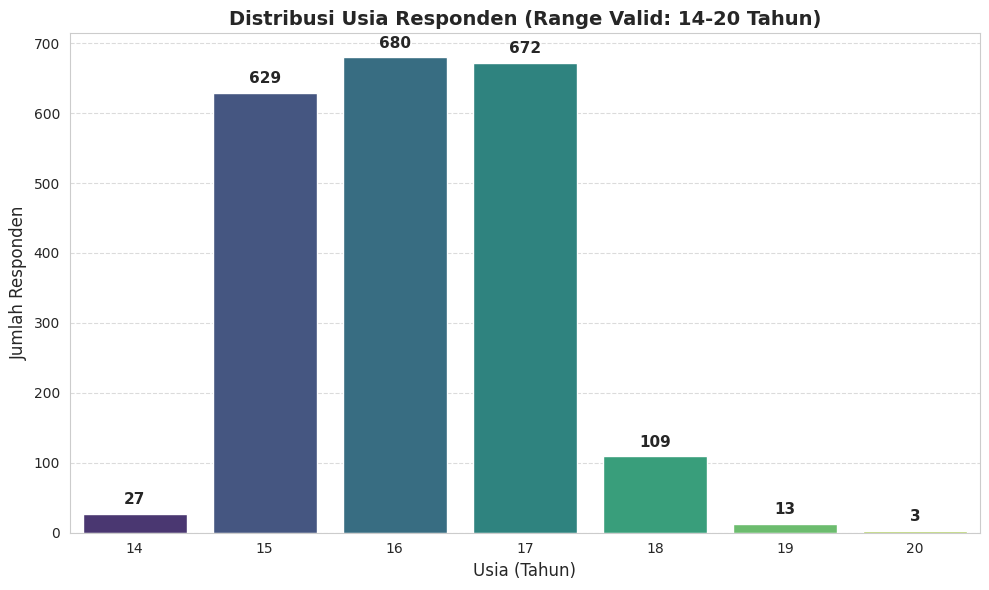


--- Statistik Usia ---
Rata-rata Usia: 16.12 Tahun
Median Usia   : 16.0 Tahun
Modus Usia    : 16.0 Tahun (Paling Banyak)
Usia Termuda  : 14.0 Tahun
Usia Tertua   : 20.0 Tahun


In [6]:
# --- VISUALISASI KHUSUS USIA - DISTRIBUSI FINAL ---

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Kita ambil hanya yang range 14-20 tahun
data_usia = df[(df['Usia'] >= 14) & (df['Usia'] <= 20)]
ax = sns.countplot(x=data_usia['Usia'].astype(int), palette='viridis')

# Judul dan Label
plt.title('Distribusi Usia Responden (Range Valid: 14-20 Tahun)', fontsize=14, fontweight='bold')
plt.xlabel('Usia (Tahun)', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)

# Menambahkan Angka di Atas Batang (Data Labels)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points',
                    fontsize=11, fontweight='bold')

# Tampilkan Grid Y saja biar rapi
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- TAMPILKAN STATISTIK ---
print("\n--- Statistik Usia ---")
print(f"Rata-rata Usia: {data_usia['Usia'].mean():.2f} Tahun")
print(f"Median Usia   : {data_usia['Usia'].median()} Tahun")
print(f"Modus Usia    : {data_usia['Usia'].mode()[0]} Tahun (Paling Banyak)")
print(f"Usia Termuda  : {data_usia['Usia'].min()} Tahun")
print(f"Usia Tertua   : {data_usia['Usia'].max()} Tahun")

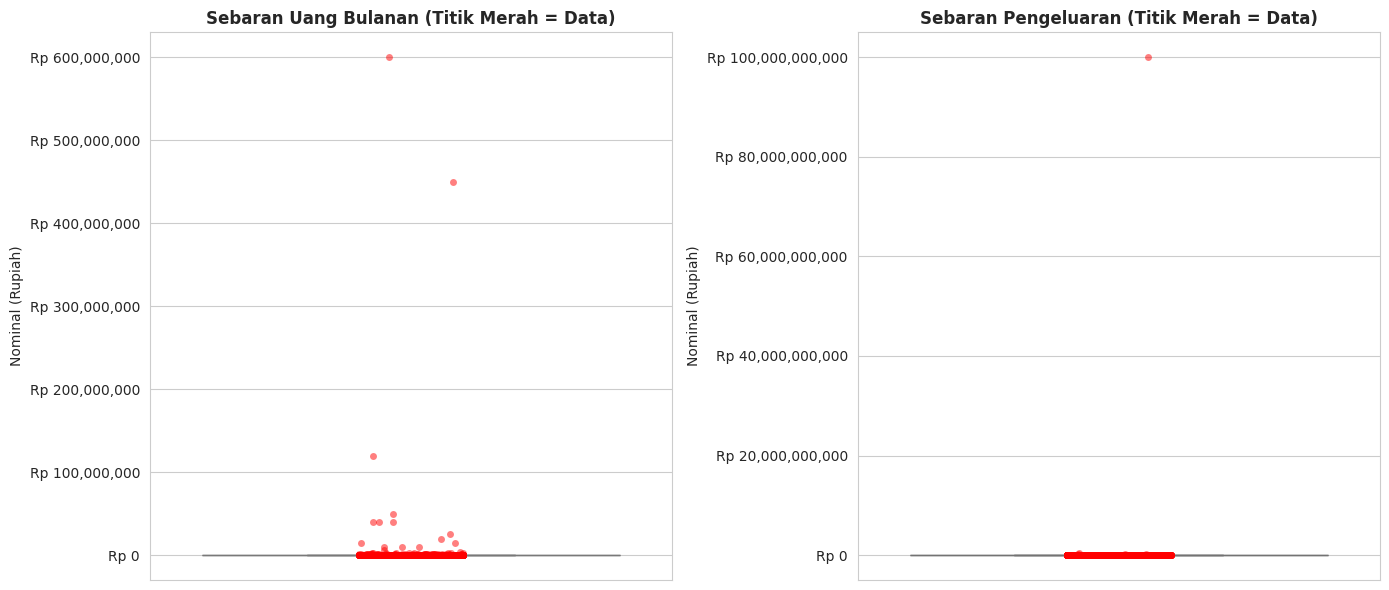


🔍 DETEKSI DATA EKSTREM (Top 5 Tertinggi)

--- 5 Siswa dengan Uang Jajan Tertinggi ---
                  Sekolah Jumlah uang bulanan
           SMA N 2 BALIGE         600,000,000
SMA N 1 SIANTAR NARUMONDA         450,000,000
       SMA N 1 LUMBANJULU         120,000,000
         SMA N 1 LAGUBOTI          50,000,000
         SMA N 1 LAGUBOTI          40,000,000

--- 5 Siswa dengan Pengeluaran Tertinggi ---
                  Sekolah Total pengeluaran dalam satu bulan
           SMA N 1 SILAEN                    100,000,099,991
           SMA N 1 SILAEN                        500,000,000
SMA N 1 SIANTAR NARUMONDA                        250,000,000
         SMA N 1 LAGUBOTI                        200,000,000
           SMA N 1 SILAEN                        200,000,000


In [7]:
# --- BAGIAN 3: VISUALISASI ANOMALI (FORMAT UANG ASLI) ---

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# mengubah format Rupiah (Rp 1,000,000)
def format_rupiah(x, pos):
    return f'Rp {x:,.0f}'
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# PLOT 1: Boxplot + Strip Plot (Uang Bulanan)
plt.subplot(1, 2, 1)
if 'Jumlah uang bulanan' in df.columns:
    sns.boxplot(y=df['Jumlah uang bulanan'], color='lightblue', showfliers=False)
    sns.stripplot(y=df['Jumlah uang bulanan'], color='red', alpha=0.5, jitter=True)

    plt.title('Sebaran Uang Bulanan (Titik Merah = Data)', fontsize=12, fontweight='bold')
    plt.ylabel('Nominal (Rupiah)')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rupiah))

# PLOT 2: Boxplot + Strip Plot (Pengeluaran)
plt.subplot(1, 2, 2)
if 'Total pengeluaran dalam satu bulan' in df.columns:
    sns.boxplot(y=df['Total pengeluaran dalam satu bulan'], color='lightgreen', showfliers=False)
    sns.stripplot(y=df['Total pengeluaran dalam satu bulan'], color='red', alpha=0.5, jitter=True)

    plt.title('Sebaran Pengeluaran (Titik Merah = Data)', fontsize=12, fontweight='bold')
    plt.ylabel('Nominal (Rupiah)')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rupiah))

plt.tight_layout()
plt.show()

# --- TAMPILKAN DATA EKSTREM DALAM TABEL ---
print("\n🔍 DETEKSI DATA EKSTREM (Top 5 Tertinggi)")

if 'Jumlah uang bulanan' in df.columns:
    print("\n--- 5 Siswa dengan Uang Jajan Tertinggi ---")
    top_uang = df[['Sekolah', 'Jumlah uang bulanan']].nlargest(5, 'Jumlah uang bulanan')

    print(top_uang.to_string(index=False, formatters={'Jumlah uang bulanan': '{:,.0f}'.format}))

if 'Total pengeluaran dalam satu bulan' in df.columns:
    print("\n--- 5 Siswa dengan Pengeluaran Tertinggi ---")
    top_keluar = df[['Sekolah', 'Total pengeluaran dalam satu bulan']].nlargest(5, 'Total pengeluaran dalam satu bulan')
    print(top_keluar.to_string(index=False, formatters={'Total pengeluaran dalam satu bulan': '{:,.0f}'.format}))

**Bagian 4**: Penanganan Anomali
> Setelah melihat grafik di atas, kita hapus/perbaiki data aneh.

In [8]:
# --- BAGIAN 4: KOREKSI LOGIKA & ANOMALI (OUTLIER)---

print(f"Jumlah data sebelum filter anomali: {len(df)}")

# 1. KOREKSI OTOMATIS (Harian -> Bulanan)
batas_ambigu = 30000
cols_uang = ['Jumlah uang bulanan', 'Total pengeluaran dalam satu bulan']

for col in cols_uang:
    if col in df.columns:
        mask_harian = (df[col] < batas_ambigu) & (df[col] > 0)
        jumlah_harian = mask_harian.sum()
        if jumlah_harian > 0:
            print(f"💡 Kolom '{col}': {jumlah_harian} data dikali 20 (asumsi harian).")
            df.loc[mask_harian, col] = df.loc[mask_harian, col] * 20

# 2. FILTER ANOMALI EKSTREM
batas_atas = 5000000
batas_bawah = 50000

for col in cols_uang:
    if col in df.columns:
        jumlah_ekstrem = (df[col] > batas_atas).sum()
        if jumlah_ekstrem > 0: print(f"Menghapus {jumlah_ekstrem} data > 5 Juta pada {col}...")
        df.loc[df[col] > batas_atas, col] = np.nan
        df.loc[df[col] < batas_bawah, col] = np.nan

# 3. HAPUS DATA KOSONG
df = df.dropna(subset=[c for c in cols_uang if c in df.columns])
print(f"✅ Jumlah data bersih siap olah: {len(df)}")

# 4. HITUNG RASIO
if 'Jumlah uang bulanan' in df.columns and 'Total pengeluaran dalam satu bulan' in df.columns:
    df['Rasio_Pengeluaran'] = df['Total pengeluaran dalam satu bulan'] / df['Jumlah uang bulanan']
    def cek_status(rasio):
        if rasio > 1.0: return 'Defisit (Nombok)'
        if rasio > 0.8: return 'Boros'
        if rasio < 0.5: return 'Hemat'
        return 'Wajar'
    df['Status_Keuangan'] = df['Rasio_Pengeluaran'].apply(cek_status)

print(f"Data sebelum filter rasio: {len(df)}")
df = df[df['Rasio_Pengeluaran'] <= 6.0]
print(f"Data sesudah filter rasio: {len(df)}")


# 5. ONE-HOT ENCODING (UBAH MEDSOS JADI MEDSOC)
col_medsos = 'Media sosial yang sering digunakan'
if col_medsos in df.columns:
    print("\nMelakukan Encoding Media Sosial...")
    medsos_dummies = df[col_medsos].str.get_dummies(sep=', ').add_prefix('Medsoc_')
    df = pd.concat([df, medsos_dummies], axis=1)

print("\nPreprocessing selesai.")

Jumlah data sebelum filter anomali: 2133
💡 Kolom 'Jumlah uang bulanan': 381 data dikali 20 (asumsi harian).
💡 Kolom 'Total pengeluaran dalam satu bulan': 50 data dikali 20 (asumsi harian).
Menghapus 15 data > 5 Juta pada Jumlah uang bulanan...
Menghapus 14 data > 5 Juta pada Total pengeluaran dalam satu bulan...
✅ Jumlah data bersih siap olah: 2029
Data sebelum filter rasio: 2029
Data sesudah filter rasio: 1995

Melakukan Encoding Media Sosial...

Preprocessing selesai.


In [9]:
cek_row = df[df['Rasio_Pengeluaran'].astype(str).str.contains('30')]
print(cek_row[['Sekolah', 'Jumlah uang bulanan', 'Total pengeluaran dalam satu bulan', 'Rasio_Pengeluaran', 'Status_Keuangan']].T)

                                                82                107   \
Sekolah                             SMA N 1 LAGUBOTI  SMA N 1 LAGUBOTI   
Jumlah uang bulanan                         650000.0          430000.0   
Total pengeluaran dalam satu bulan          450000.0          400000.0   
Rasio_Pengeluaran                           0.692308          0.930233   
Status_Keuangan                                Wajar             Boros   

                                                161               169   \
Sekolah                             SMA N 1 LAGUBOTI  SMA N 1 LAGUBOTI   
Jumlah uang bulanan                         650000.0          650000.0   
Total pengeluaran dalam satu bulan          500000.0          500000.0   
Rasio_Pengeluaran                           0.769231          0.769231   
Status_Keuangan                                Wajar             Wajar   

                                                170               227   \
Sekolah                             

Kembali melakukan visualisasi anomali untuk melihat apakah perbaikan telah selesai.

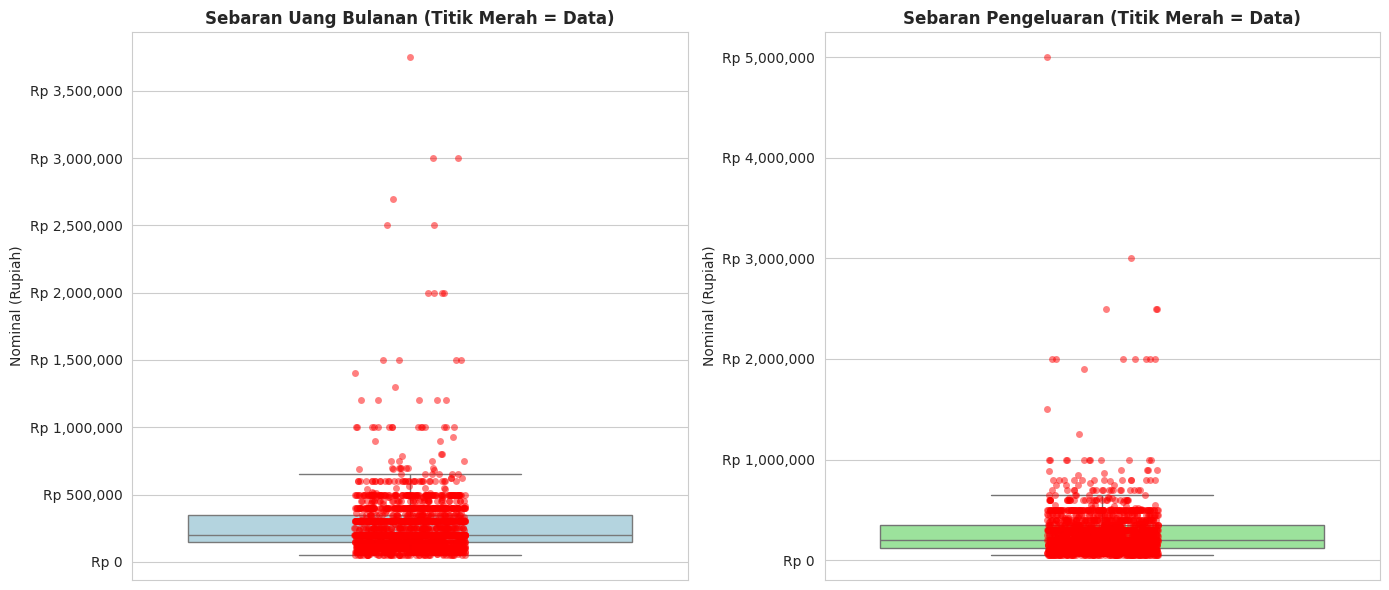


🔍 DETEKSI DATA EKSTREM (Top 5 Tertinggi)

--- 5 Siswa dengan Uang Jajan Tertinggi ---
                  Sekolah Jumlah uang bulanan
           SMA N 1 BALIGE           3,750,000
SMA N 1 SIANTAR NARUMONDA           3,000,000
SMA N 1 SIANTAR NARUMONDA           3,000,000
           SMA N 2 BALIGE           2,700,000
         SMA N 1 LAGUBOTI           2,500,000

--- 5 Siswa dengan Pengeluaran Tertinggi ---
                  Sekolah Total pengeluaran dalam satu bulan
SMA N 1 SIANTAR NARUMONDA                          5,000,000
         SMA N 1 LAGUBOTI                          3,000,000
         SMA N 1 LAGUBOTI                          2,500,000
           SMA N 1 BALIGE                          2,500,000
           SMA N 1 SILAEN                          2,500,000


In [10]:
# --- VISUALISASI ANOMALI (2) - (FORMAT UANG ASLI) ---

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Fungsi untuk mengubah angka biasa jadi format Rupiah (Rp 1,000,000)
def format_rupiah(x, pos):
    return f'Rp {x:,.0f}'

# Pastikan style visualisasi bersih
sns.set_style("whitegrid")

# Kita hanya buat 2 Plot sekarang (Scatter Plot dihapus)
plt.figure(figsize=(14, 6))

# PLOT 1: Boxplot + Strip Plot (Uang Bulanan)
plt.subplot(1, 2, 1)
if 'Jumlah uang bulanan' in df.columns:
    # Boxplot (tanpa outlier bawaan)
    sns.boxplot(y=df['Jumlah uang bulanan'], color='lightblue', showfliers=False)
    # Strip Plot (titik data asli)
    sns.stripplot(y=df['Jumlah uang bulanan'], color='red', alpha=0.5, jitter=True)

    plt.title('Sebaran Uang Bulanan (Titik Merah = Data)', fontsize=12, fontweight='bold')
    plt.ylabel('Nominal (Rupiah)')

    # TERAPKAN FORMAT UANG KE SUMBU Y
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rupiah))

# PLOT 2: Boxplot + Strip Plot (Pengeluaran)
plt.subplot(1, 2, 2)
if 'Total pengeluaran dalam satu bulan' in df.columns:
    sns.boxplot(y=df['Total pengeluaran dalam satu bulan'], color='lightgreen', showfliers=False)
    sns.stripplot(y=df['Total pengeluaran dalam satu bulan'], color='red', alpha=0.5, jitter=True)

    plt.title('Sebaran Pengeluaran (Titik Merah = Data)', fontsize=12, fontweight='bold')
    plt.ylabel('Nominal (Rupiah)')

    # TERAPKAN FORMAT UANG KE SUMBU Y
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rupiah))

plt.tight_layout()
plt.show()

# --- TAMPILKAN DATA EKSTREM DALAM TABEL ---
print("\n🔍 DETEKSI DATA EKSTREM (Top 5 Tertinggi)")

if 'Jumlah uang bulanan' in df.columns:
    print("\n--- 5 Siswa dengan Uang Jajan Tertinggi ---")
    top_uang = df[['Sekolah', 'Jumlah uang bulanan']].nlargest(5, 'Jumlah uang bulanan')
    # Tampilkan tanpa index agar rapi
    print(top_uang.to_string(index=False, formatters={'Jumlah uang bulanan': '{:,.0f}'.format}))

if 'Total pengeluaran dalam satu bulan' in df.columns:
    print("\n--- 5 Siswa dengan Pengeluaran Tertinggi ---")
    top_keluar = df[['Sekolah', 'Total pengeluaran dalam satu bulan']].nlargest(5, 'Total pengeluaran dalam satu bulan')
    print(top_keluar.to_string(index=False, formatters={'Total pengeluaran dalam satu bulan': '{:,.0f}'.format}))

**Bagian 5: Export Data Akhir**
> Simpan data yang sudah bersih dan bebas anomali.

In [11]:
# --- BAGIAN 5: FINALISASI DATA & EXPORT ---

print("Memulai proses export...")

# 1. PERBAIKI TIPE DATA
numeric_cols = ['Jumlah uang bulanan', 'Total pengeluaran dalam satu bulan', 'Usia', 'Rasio_Pengeluaran']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# PERUBAHAN DI SINI: Cek kolom yang berawalan 'Medsoc_'
medsoc_cols = [c for c in df.columns if c.startswith('Medsoc_')]
if medsoc_cols:
    # Ubah jadi integer (0/1)
    df[medsoc_cols] = df[medsoc_cols].fillna(0).astype(int)

# 2. EXPORT DATA
filename_base = 'cleaned_processed_final'

df.to_excel(f'{filename_base}.xlsx', index=False)
df.to_csv(f'{filename_base}.csv', index=False, encoding='utf-8-sig', sep=',')

print(f"✅ File berhasil disimpan: {filename_base}.xlsx & .csv")
print("\n--- Contoh Kolom Baru ---")
# Tampilkan contoh kolom Medsoc
print([col for col in df.columns if 'Medsoc' in col][:5])

Memulai proses export...
✅ File berhasil disimpan: cleaned_processed_final.xlsx & .csv

--- Contoh Kolom Baru ---
['Medsoc_Discord', 'Medsoc_Facebook', 'Medsoc_Instagram', 'Medsoc_Line', 'Medsoc_Pinterest']


**EDA** - Exploratory Data Analysis (Analisis Data Eksploratif)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import PercentFormatter

In [13]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
df = pd.read_csv('cleaned_processed_final.csv')

In [15]:
# Mengubah Nama Fitur
# Definisi kamus (mapping)
rename_mapping = {
    'Timestamp': 'Timestamp',
    'Usia': 'age',
    'JK': 'gender',
    'Sekolah': 'school',
    'Kelas': 'grade_level',
    'Jumlah uang bulanan': 'monthly_allowance',
    'Total pengeluaran dalam satu bulan': 'monthly_total_spending',
    'Seberapa besar pengaruh teman-teman Anda dalam pengambilan keputusan sehari-hari (contohnya dalam memilih pakaian, tempat nongkrong dan barang yang ingin dibeli)?': 'Peer_influance_decision',
    'Seberapa besar rasa takut Anda merasa ditolak dalam pertemanan jika dianggap ketinggalan tren atau tidak mengikuti gaya teman-teman Anda?': 'fear_of_rejection',
    'Seberapa sering Anda membeli suatu barang karena diajak atau dipengaruhi oleh teman Anda, bukan karena kebutuhan pribadi?': 'peer_influenced_buying',
    'Dalam seminggu berapa kali Anda biasanya keluar untuk nongkrong  bersama teman?': 'hangout_frequency',
    'Media sosial yang sering digunakan': 'most_used_social_media',
    'Lama rata-rata Anda menggunakan media sosial': 'daily_social_media_hours',
    'Seberapa besar pengaruh rekomendasi influencer terhadap pilihan belanja atau gaya hidup Anda?': 'influencer_impact',
    'Dalam satu bulan, berapa kali Anda melakukan pembelian melalui platform belanja online seperti Shopee, Tokopedia dan Tiktok Shop?': 'online_shopping_frequency',
    'Seberapa sering Anda makan atau membeli jajanan diluar rumah dalam seminggu?': 'eating_out_frequency',
    'Seberapa sering Anda membeli barang dalam satu bulan (termasuk jajan, nongkrong, belanja dan kebutuhan lainnya)?': 'freq_total_purchase_monthly',
    'Seberapa sering Anda membeli barang secara spontan tanpa perencanaan sebelumnya (impulsive buying)?': 'freq_impulsive_buying',
    'Saya merasa perlu membeli barang-barang yang sedang tren agar saya dapat diterima dalam kelompok pertemanan saya': 'attitude_need_trend_acceptance',
    'Sebagian besar uang saku saya habis karena kegiatan bersama teman, seperti nongkrong, makan diluar atau mengikuti tren lain?': 'attitude_money_spent_on_peers',
    'Saya sering merasa terdorong untuk mencoba tempat-tempat yang sedang viral, meskipun sebenarnya tempat tersebut tidak terlalu menarik bagi saya': 'attitude_driven_by_viral',
    'Saya sering merasa terdorong untuk mencoba tempat-tempat yang sedang tren di media sosial karena banyak teman saya yang melakukannya': 'trend_place_pressure',
    'Saya rela mengurangi atau menghemat uang makan dan transportasi agar bisa membeli barang atau mengikuti tren yang sedang populer di sekolah': 'saving_for_trend',
    'Frekuensi saya nongkrong di kafe atau tempat hangout tertentu meningkat karena sering diajak atau dipengaruhi oleh teman':'hangout_increase_friends',
    'Rasio_Pengeluaran':'spending_ratio',
    'Status_Keuangan':'financial_status'
}

# Menerapkan perubahan nama kolom
df = df.rename(columns=rename_mapping)

# Memverifikasi hasilnya dengan menampilkan daftar kolom baru
print("Daftar Nama Fitur Setelah Rename")
print(df.columns.tolist())

Daftar Nama Fitur Setelah Rename
['Timestamp', 'age', 'gender', 'school', 'grade_level', 'monthly_allowance', 'Peer_influance_decision', 'fear_of_rejection', 'peer_influenced_buying', 'hangout_frequency', 'most_used_social_media', 'daily_social_media_hours', 'influencer_impact', 'online_shopping_frequency', 'eating_out_frequency', 'monthly_total_spending', 'freq_total_purchase_monthly', 'freq_impulsive_buying', 'attitude_need_trend_acceptance', 'attitude_money_spent_on_peers', 'trend_place_pressure', 'saving_for_trend', 'hangout_increase_friends', 'spending_ratio', 'financial_status', 'Medsoc_Discord', 'Medsoc_Facebook', 'Medsoc_Instagram', 'Medsoc_Line', 'Medsoc_Pinterest', 'Medsoc_Talkin', 'Medsoc_Telegram', 'Medsoc_Threads', 'Medsoc_Tidak Ada', 'Medsoc_TikTok', 'Medsoc_Twitter/X', 'Medsoc_VK', 'Medsoc_WeChat', 'Medsoc_WhatsApp', 'Medsoc_Yeetalk', 'Medsoc_YouTube']


In [16]:
print("5 Baris Pertama Dataset:")
print(df.head())

5 Baris Pertama Dataset:
                 Timestamp   age     gender            school grade_level  \
0  2025-11-26 08:51:25.968  18.0  Laki-laki  SMA N 1 LAGUBOTI         XII   
1  2025-11-26 08:51:44.569  17.0  Perempuan  SMA N 1 LAGUBOTI         XII   
2  2025-11-26 08:52:35.154  17.0  Laki-laki  SMA N 1 LAGUBOTI         XII   
3  2025-11-26 08:52:38.027  17.0  Laki-laki  SMA N 1 LAGUBOTI         XII   
4  2025-11-26 08:52:57.471  17.0  Laki-laki  SMA N 1 LAGUBOTI         XII   

   monthly_allowance Peer_influance_decision        fear_of_rejection  \
0           200000.0                   Cukup            Sedikit Takut   
1           100000.0                   Cukup            Sedikit Takut   
2           280000.0                   Cukup              Cukup Takut   
3           200000.0                 Sedikit  Tidak Takut Sama Sekali   
4           240000.0                 Sedikit            Sedikit Takut   

  peer_influenced_buying      hangout_frequency  ... Medsoc_Telegram  \
0

In [17]:
print("\nInformasi Dataset:")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")


Informasi Dataset:
Jumlah Baris: 1995
Jumlah Kolom: 41


In [18]:
print("\nTipe Data Kolom:")
print(df.dtypes)


Tipe Data Kolom:
Timestamp                          object
age                               float64
gender                             object
school                             object
grade_level                        object
monthly_allowance                 float64
Peer_influance_decision            object
fear_of_rejection                  object
peer_influenced_buying             object
hangout_frequency                  object
most_used_social_media             object
daily_social_media_hours           object
influencer_impact                  object
online_shopping_frequency          object
eating_out_frequency               object
monthly_total_spending            float64
freq_total_purchase_monthly        object
freq_impulsive_buying              object
attitude_need_trend_acceptance     object
attitude_money_spent_on_peers      object
trend_place_pressure               object
saving_for_trend                   object
hangout_increase_friends           object
spending_ratio  

In [19]:
age_mode = df['age'].mode()[0]
df['age'].fillna(age_mode, inplace=True)

most_used_social_media_mode = df['most_used_social_media'].mode()[0]
df['most_used_social_media'].fillna(most_used_social_media_mode, inplace=True)

print("Missing values after imputation:")
print(df[['age', 'most_used_social_media']].isnull().sum())

Missing values after imputation:
age                       0
most_used_social_media    0
dtype: int64


/tmp/ipython-input-3553604147.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_mode, inplace=True)
/tmp/ipython-input-3553604147.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [20]:
print("\nJumlah Missing Values per Kolom:")
print(df.isnull().sum())


Jumlah Missing Values per Kolom:
Timestamp                         0
age                               0
gender                            0
school                            0
grade_level                       0
monthly_allowance                 0
Peer_influance_decision           0
fear_of_rejection                 0
peer_influenced_buying            0
hangout_frequency                 0
most_used_social_media            0
daily_social_media_hours          0
influencer_impact                 0
online_shopping_frequency         0
eating_out_frequency              0
monthly_total_spending            0
freq_total_purchase_monthly       0
freq_impulsive_buying             0
attitude_need_trend_acceptance    0
attitude_money_spent_on_peers     0
trend_place_pressure              0
saving_for_trend                  0
hangout_increase_friends          0
spending_ratio                    0
financial_status                  0
Medsoc_Discord                    0
Medsoc_Facebook               

In [21]:
print("\nStatistik Deskriptif Kolom Numerik:")
print(df.describe())


Statistik Deskriptif Kolom Numerik:
               age  monthly_allowance  monthly_total_spending  spending_ratio  \
count  1995.000000       1.995000e+03            1.995000e+03     1995.000000   
mean     16.107268       2.715281e+05            2.652639e+05        1.142452   
std       0.951967       2.433026e+05            2.539277e+05        0.792721   
min      14.000000       5.000000e+04            5.000000e+04        0.035714   
25%      15.000000       1.500000e+05            1.250000e+05        0.726319   
50%      16.000000       2.000000e+05            2.000000e+05        1.000000   
75%      17.000000       3.500000e+05            3.500000e+05        1.250000   
max      20.000000       3.750000e+06            5.000000e+06        6.000000   

       Medsoc_Discord  Medsoc_Facebook  Medsoc_Instagram  Medsoc_Line  \
count     1995.000000      1995.000000       1995.000000  1995.000000   
mean         0.002506         0.069173          0.788972     0.000501   
std          0

**Distribusi Variabel Demografis**

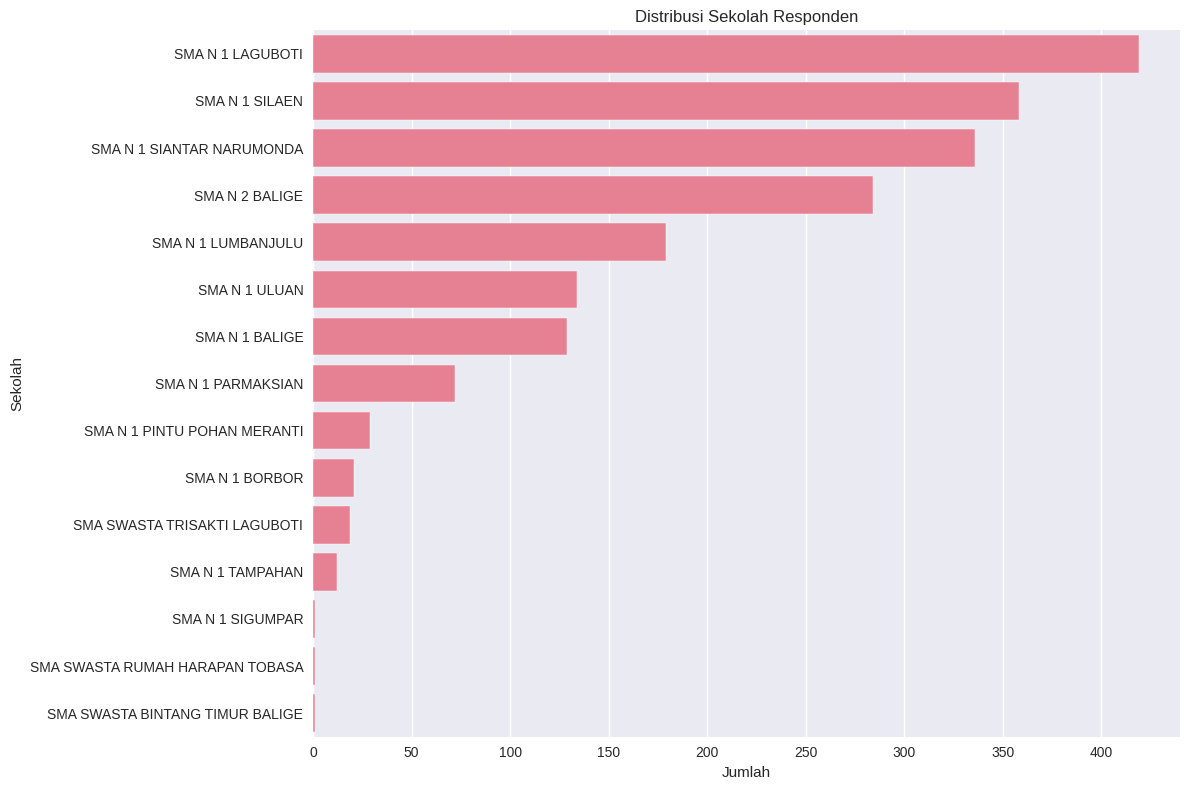

In [22]:
plt.figure(figsize=(12, 8))
sns.countplot(y='school', data=df, order=df['school'].value_counts().index)
plt.title('Distribusi Sekolah Responden')
plt.xlabel('Jumlah')
plt.ylabel('Sekolah')
plt.tight_layout()
plt.savefig('school_distribution.png')
plt.show()

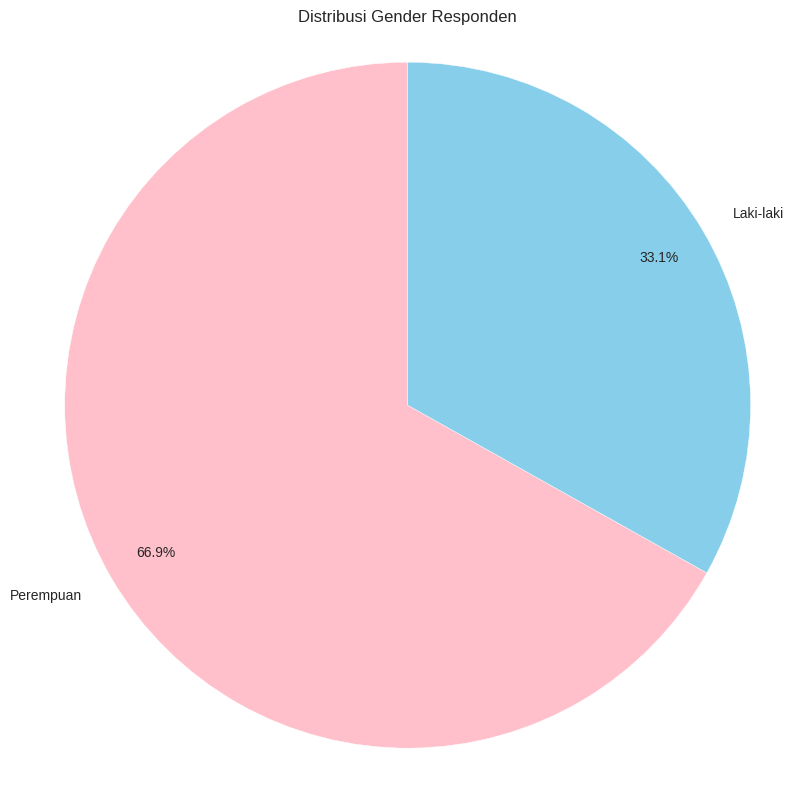

In [23]:
plt.figure(figsize=(8,8))
gender_counts = df['gender'].value_counts()
labels = gender_counts.index
sizes = gender_counts.values
colors = ['pink', 'skyblue']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=colors)
plt.title('Distribusi Gender Responden')
plt.axis('equal')
plt.tight_layout()
plt.savefig('gender_distribution_pie.png')
plt.show()

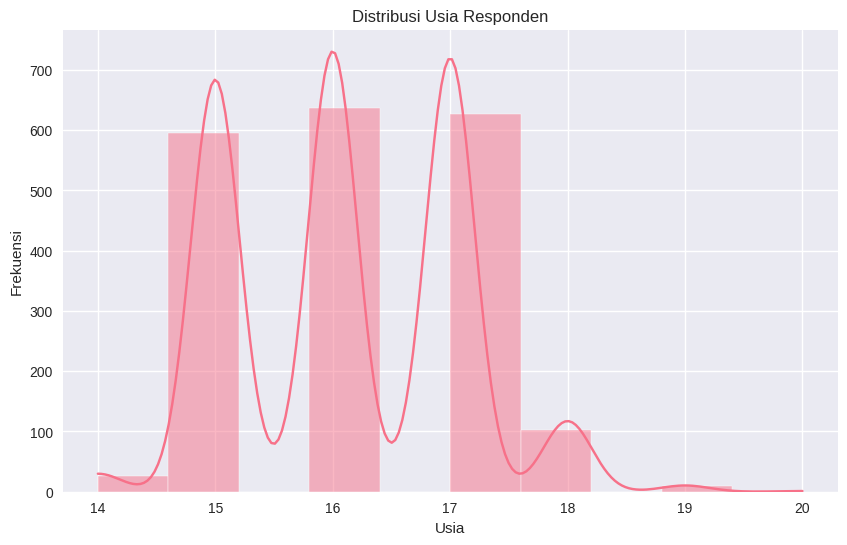

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=10, kde=True)
plt.title('Distribusi Usia Responden')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.savefig('age_distribution.png')
plt.show()

Distribusi Kelas

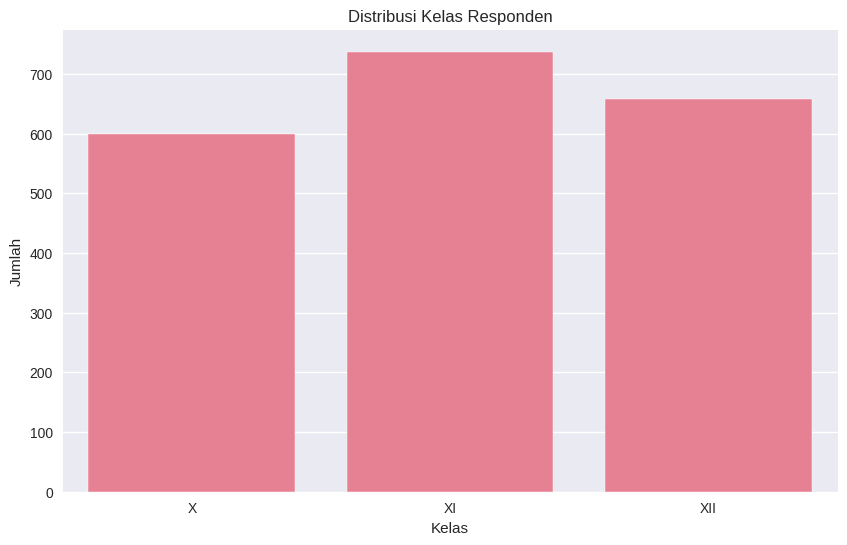

In [25]:
grade_order = ['X', 'XI', 'XII']

df['grade_level'] = pd.Categorical(df['grade_level'], categories=grade_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.countplot(x='grade_level', data=df)
plt.title('Distribusi Kelas Responden')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.savefig('class_distribution.png')
plt.show()

**Pengaruh Teman Sebaya dan media Sosial**



Pengaruh Teman dalam Pengambilan Keputusan

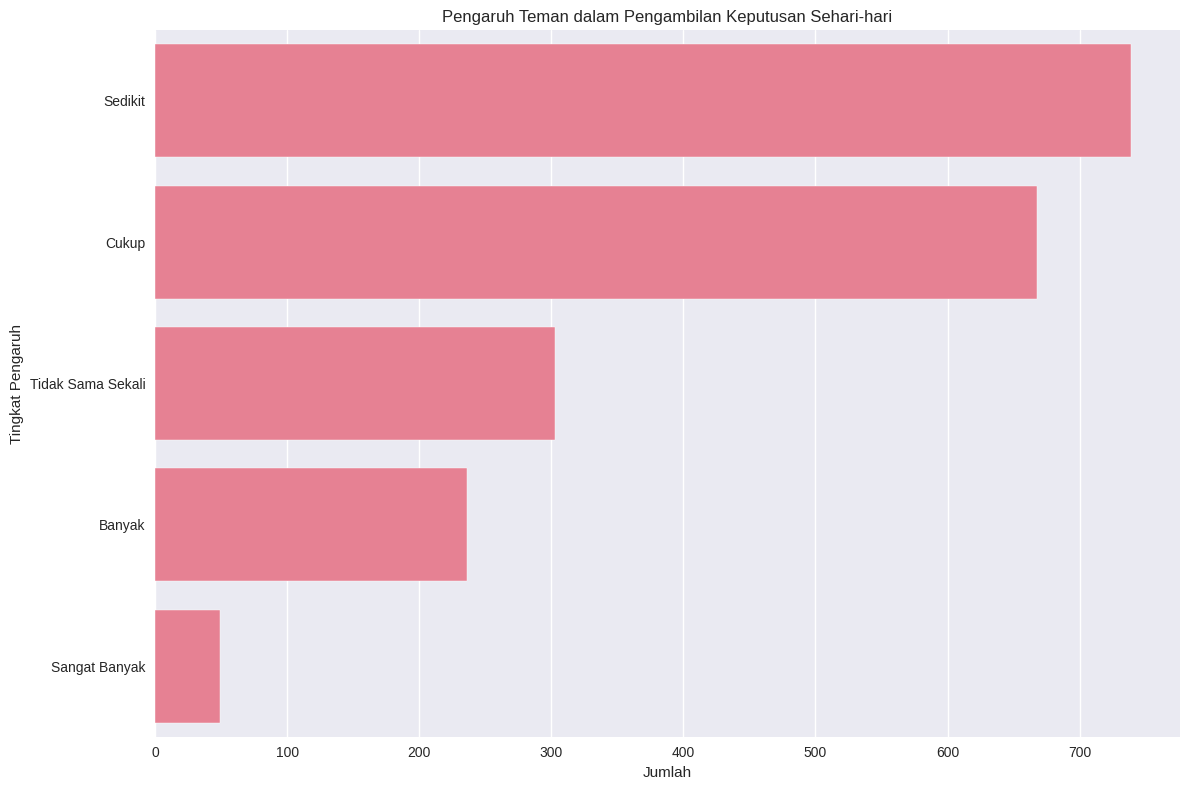

In [26]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Peer_influance_decision',
              data=df, order=df['Peer_influance_decision'].value_counts().index)
plt.title('Pengaruh Teman dalam Pengambilan Keputusan Sehari-hari')
plt.xlabel('Jumlah')
plt.ylabel('Tingkat Pengaruh')
plt.tight_layout()
plt.savefig('peer_influence.png')
plt.show()

Rasa takut di tolak jika mengikuti trend

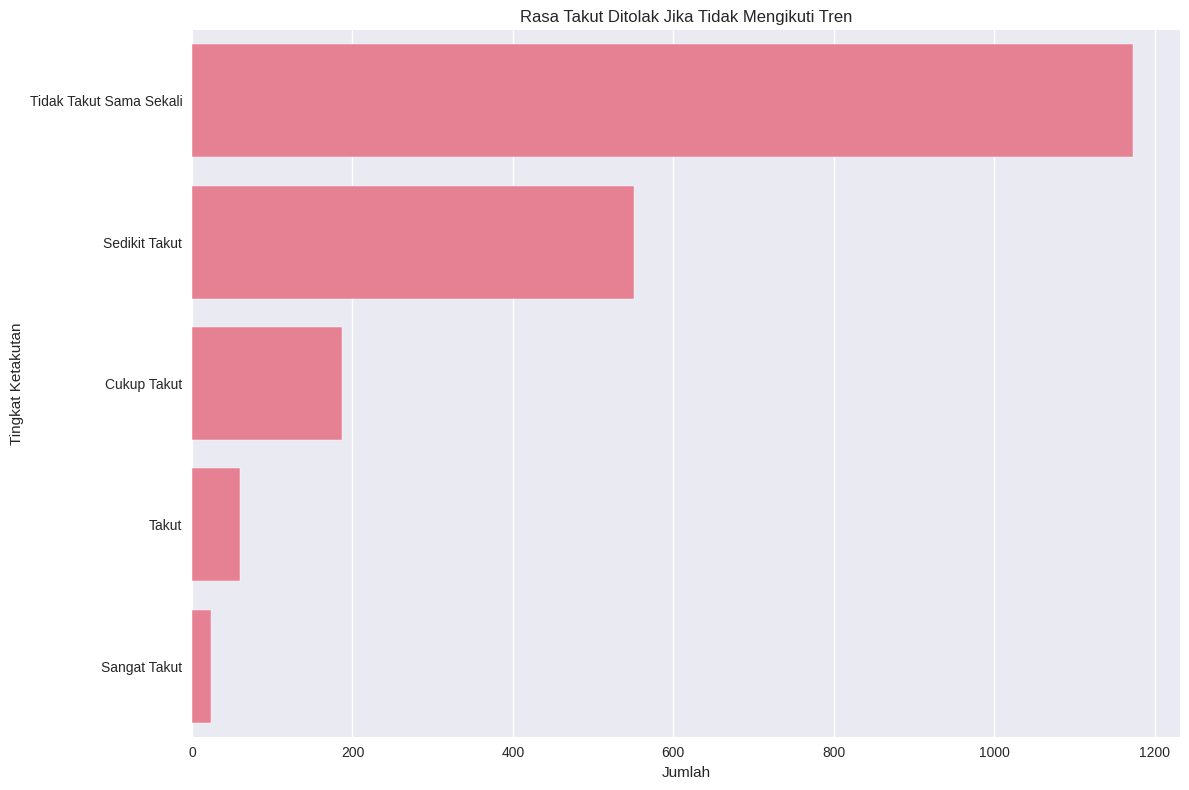

In [27]:
plt.figure(figsize=(12, 8))
sns.countplot(y='fear_of_rejection',
              data=df, order=df['fear_of_rejection'].value_counts().index)
plt.title('Rasa Takut Ditolak Jika Tidak Mengikuti Tren')
plt.xlabel('Jumlah')
plt.ylabel('Tingkat Ketakutan')
plt.tight_layout()
plt.savefig('fear_of_rejection.png')
plt.show()

Frekuensi Pembelian karena pengaruh Teman

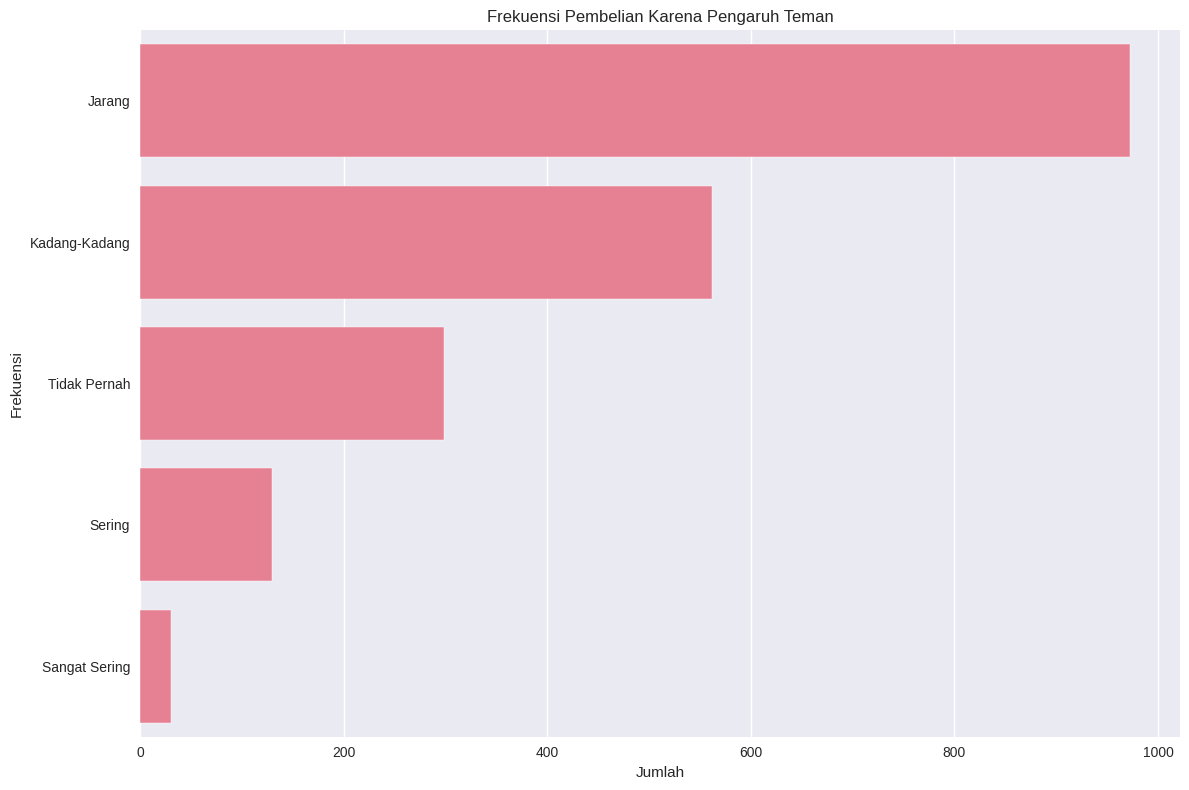

In [28]:
plt.figure(figsize=(12, 8))
sns.countplot(y='peer_influenced_buying',
              data=df, order=df['peer_influenced_buying'].value_counts().index)
plt.title('Frekuensi Pembelian Karena Pengaruh Teman')
plt.xlabel('Jumlah')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.savefig('friend_influenced_buying.png')
plt.show()

**Analisis Penggunaan Media Sosial**



> Media Sosial Yang sering digunakan



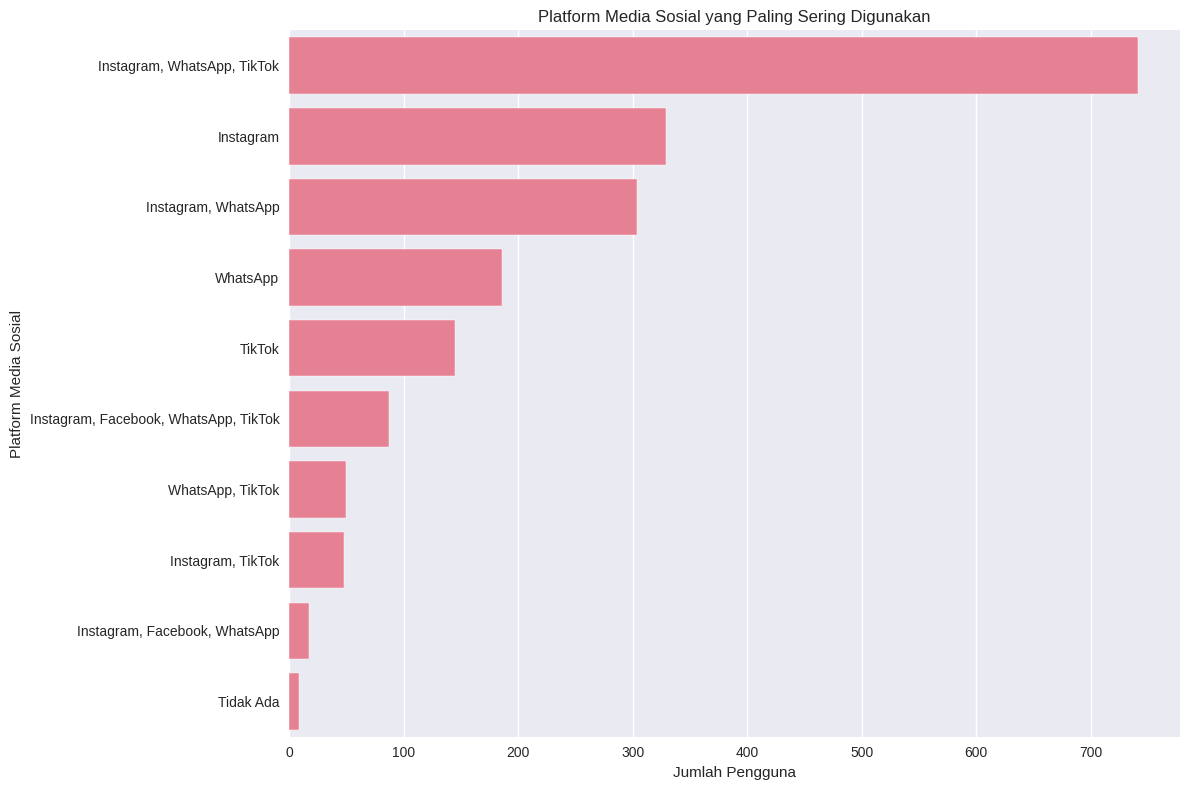

In [29]:
plt.figure(figsize=(12, 8))
social_media_counts = df['most_used_social_media'].value_counts().head(10)
sns.barplot(x=social_media_counts.values, y=social_media_counts.index)
plt.title('Platform Media Sosial yang Paling Sering Digunakan')
plt.xlabel('Jumlah Pengguna')
plt.ylabel('Platform Media Sosial')
plt.tight_layout()
plt.savefig('social_media_platforms.png')
plt.show()

Rata - rata penggunaan media sosial per hari

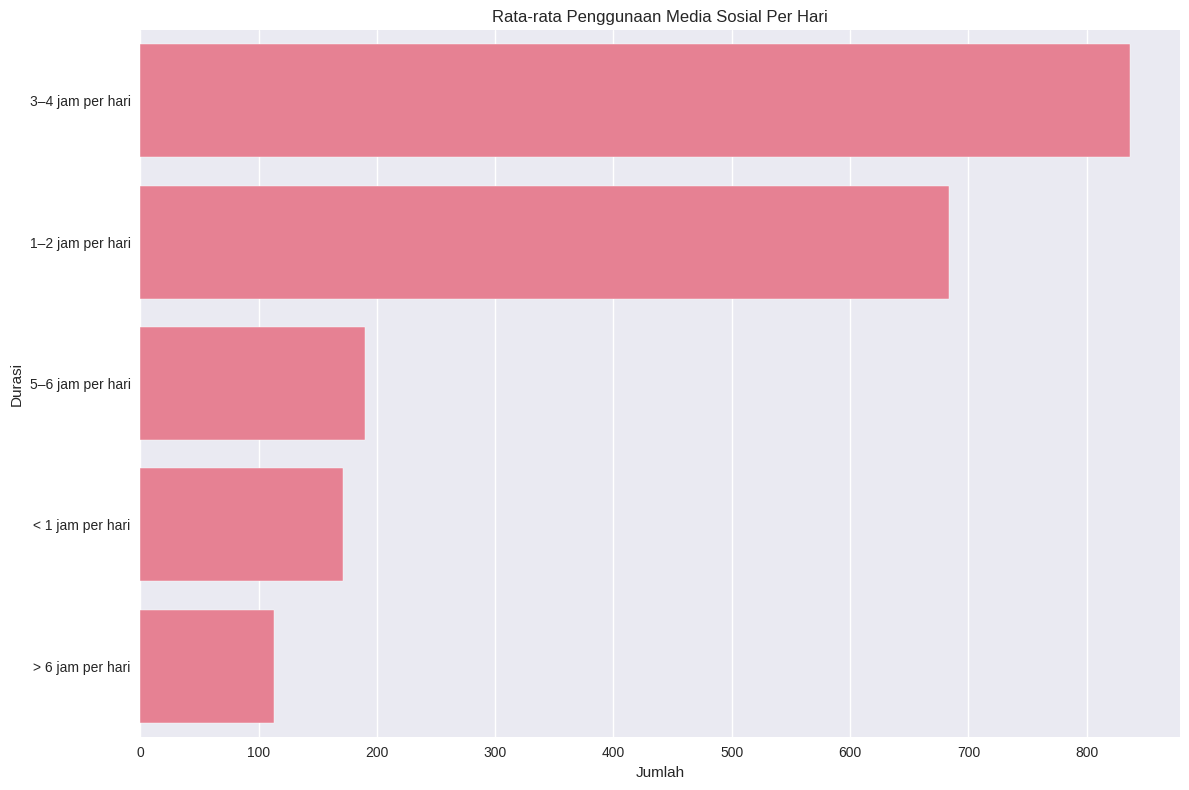

In [30]:
plt.figure(figsize=(12, 8))
sns.countplot(y='daily_social_media_hours',
              data=df, order=df['daily_social_media_hours'].value_counts().index)
plt.title('Rata-rata Penggunaan Media Sosial Per Hari')
plt.xlabel('Jumlah')
plt.ylabel('Durasi')
plt.tight_layout()
plt.savefig('social_media_usage_time.png')
plt.show()

Pengaruh Influencer Terhadap Gaya Hidup

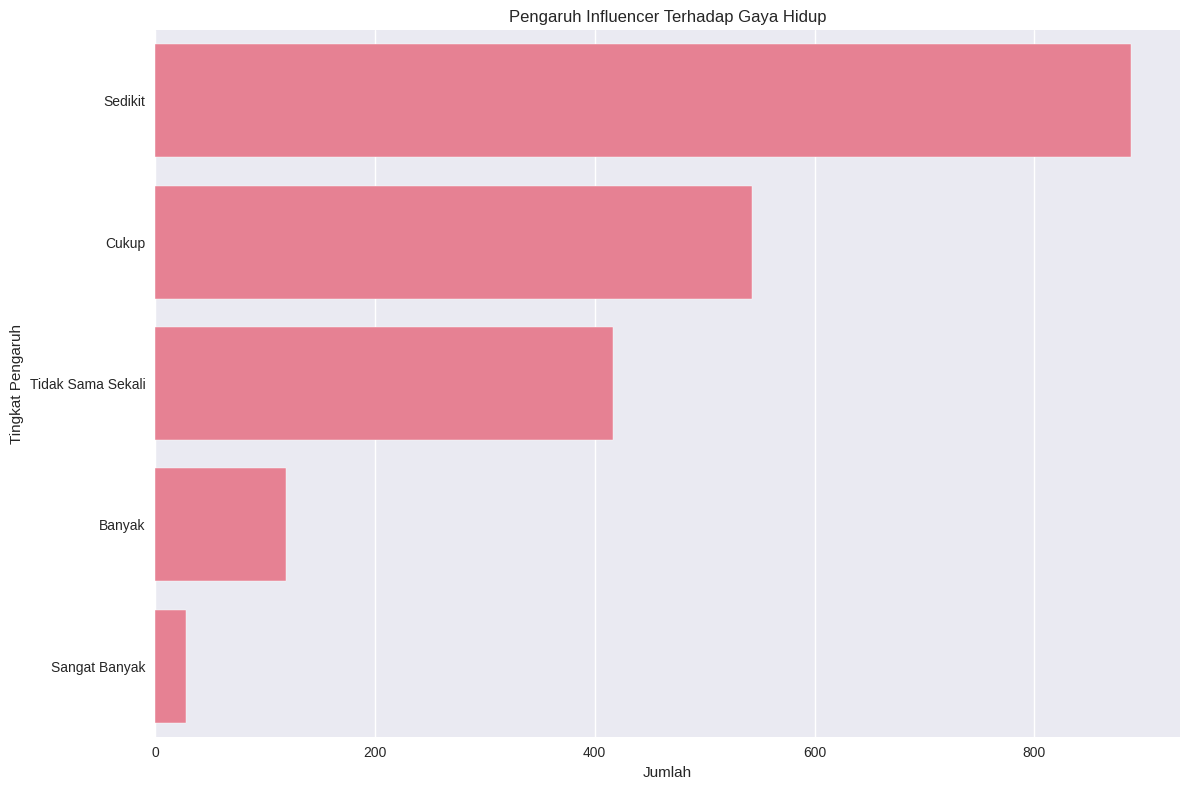

In [31]:
plt.figure(figsize=(12, 8))
sns.countplot(y='influencer_impact',
              data=df, order=df['influencer_impact'].value_counts().index)
plt.title('Pengaruh Influencer Terhadap Gaya Hidup')
plt.xlabel('Jumlah')
plt.ylabel('Tingkat Pengaruh')
plt.tight_layout()
plt.savefig('influencer_impact.png')
plt.show()

**Analisis Pola Pengeluaran**



> Distribusi uang saku bulanan



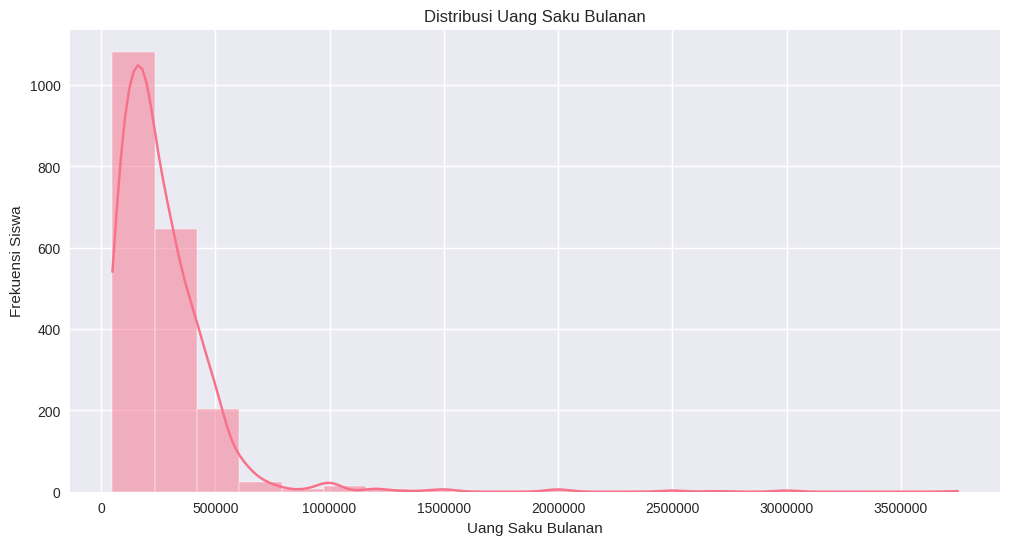

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(df['monthly_allowance'], bins=20, kde=True)
plt.title('Distribusi Uang Saku Bulanan')
plt.xlabel('Uang Saku Bulanan')
plt.ylabel('Frekuensi Siswa')
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.savefig('monthly_allowance_distribution.png')
plt.show()

Distribusi Total Pengeluaran Bulanan

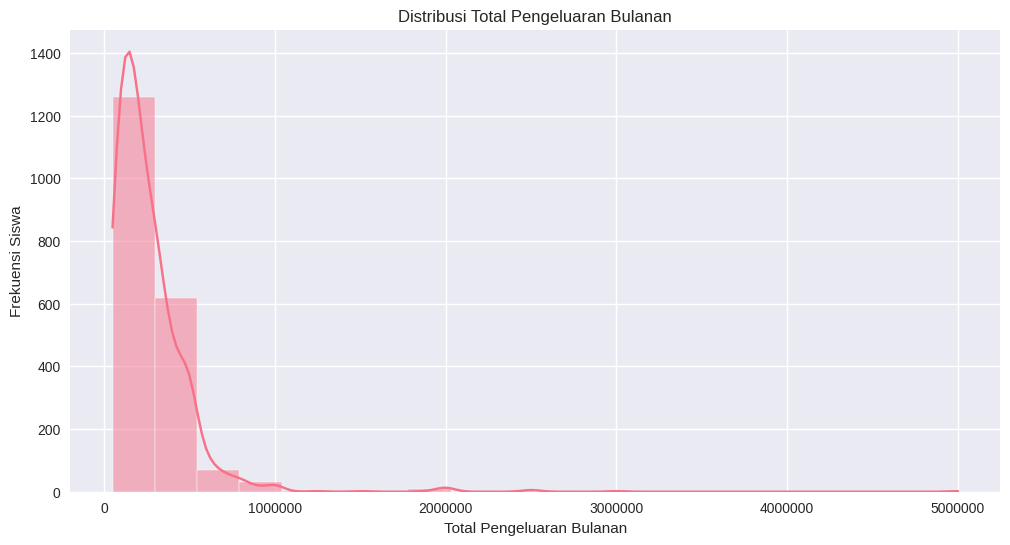

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(df['monthly_total_spending'], bins=20, kde=True)
plt.title('Distribusi Total Pengeluaran Bulanan')
plt.xlabel('Total Pengeluaran Bulanan')
plt.ylabel('Frekuensi Siswa')
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.savefig('monthly_spending_distribution.png')
plt.show()

Status Keuangan

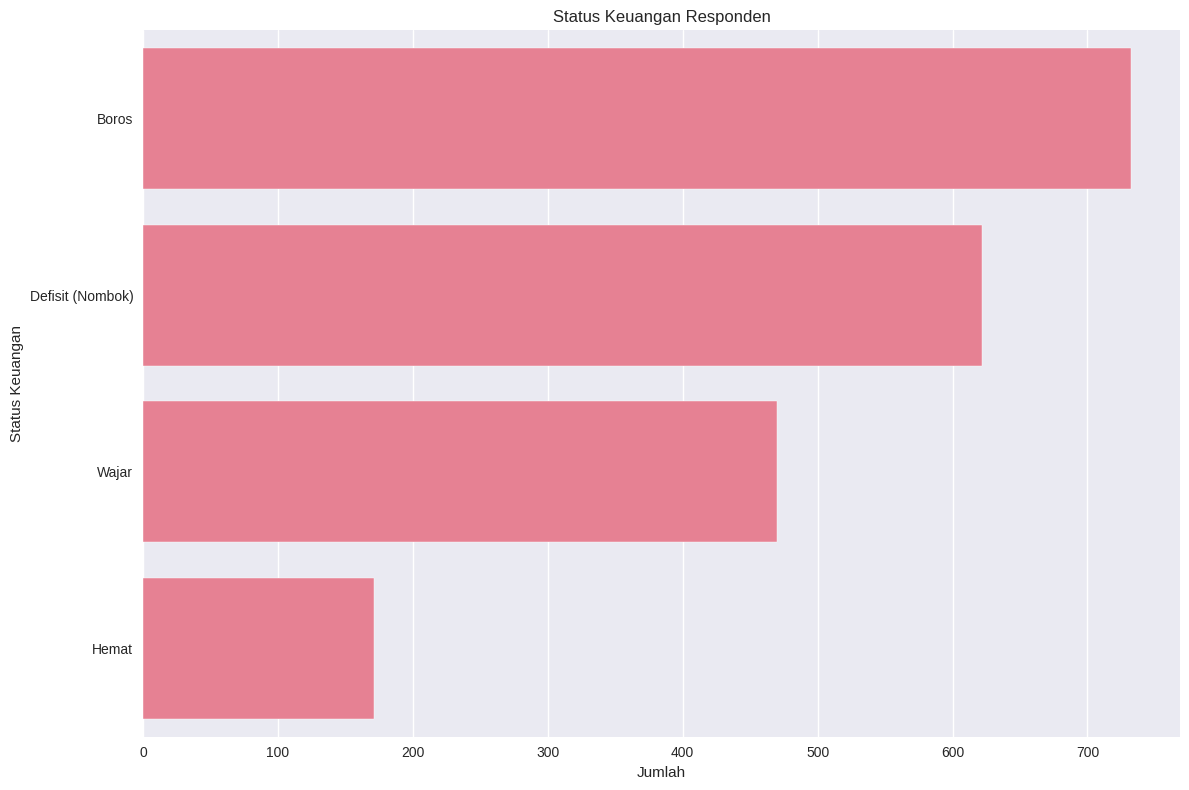

In [34]:
plt.figure(figsize=(12, 8))
sns.countplot(y='financial_status', data=df, order=df['financial_status'].value_counts().index)
plt.title('Status Keuangan Responden')
plt.xlabel('Jumlah')
plt.ylabel('Status Keuangan')
plt.tight_layout()
plt.savefig('financial_status.png')
plt.show()

Rasio Pengeluaran Terhadap Uang Saku

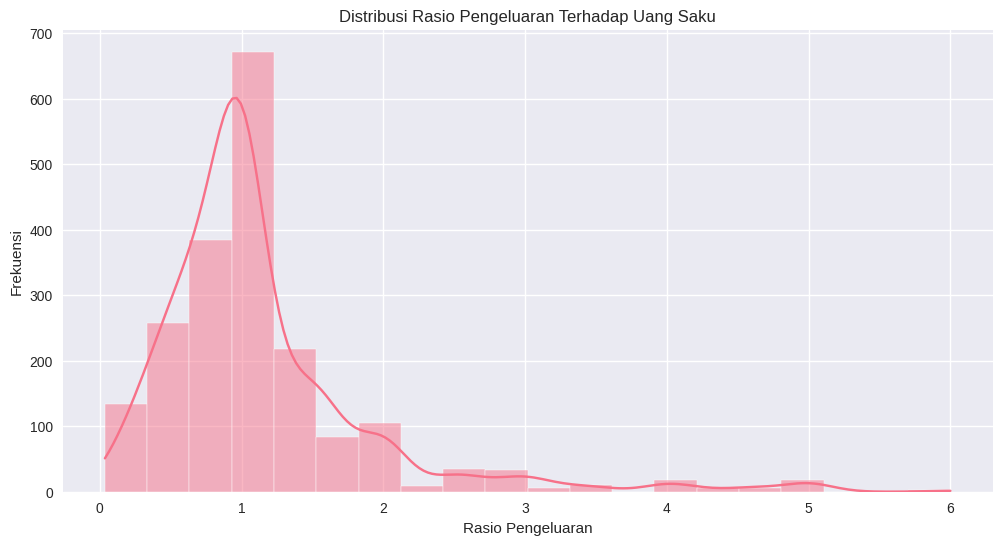

In [35]:
plt.figure(figsize=(12, 6))
sns.histplot(df['spending_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Pengeluaran Terhadap Uang Saku')
plt.xlabel('Rasio Pengeluaran')
plt.ylabel('Frekuensi')
plt.savefig('spending_ratio_distribution.png')
plt.show()

**Analisis Hubungan Antara variabel-variabel**


> Hubungan antara uang saku dan total pengeluaran



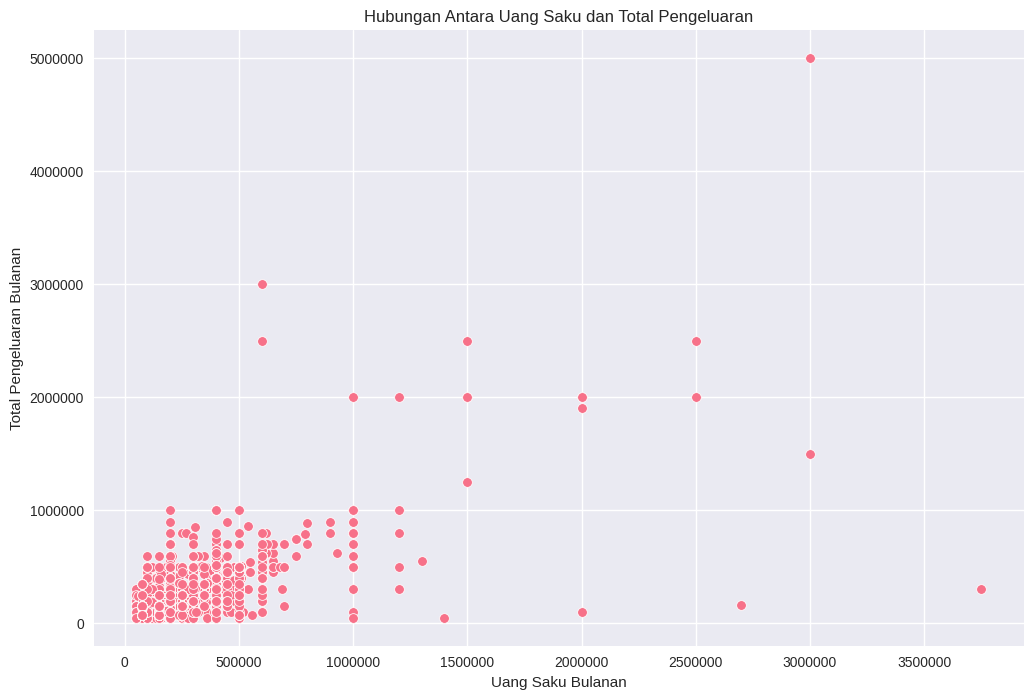

In [36]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='monthly_allowance', y='monthly_total_spending', data=df)
plt.title('Hubungan Antara Uang Saku dan Total Pengeluaran')
plt.xlabel('Uang Saku Bulanan')
plt.ylabel('Total Pengeluaran Bulanan')
plt.ticklabel_format(style='plain', axis='both')
plt.savefig('allowance_vs_spending.png')
plt.show()

Hubungan antara gender dan pengaruh teman

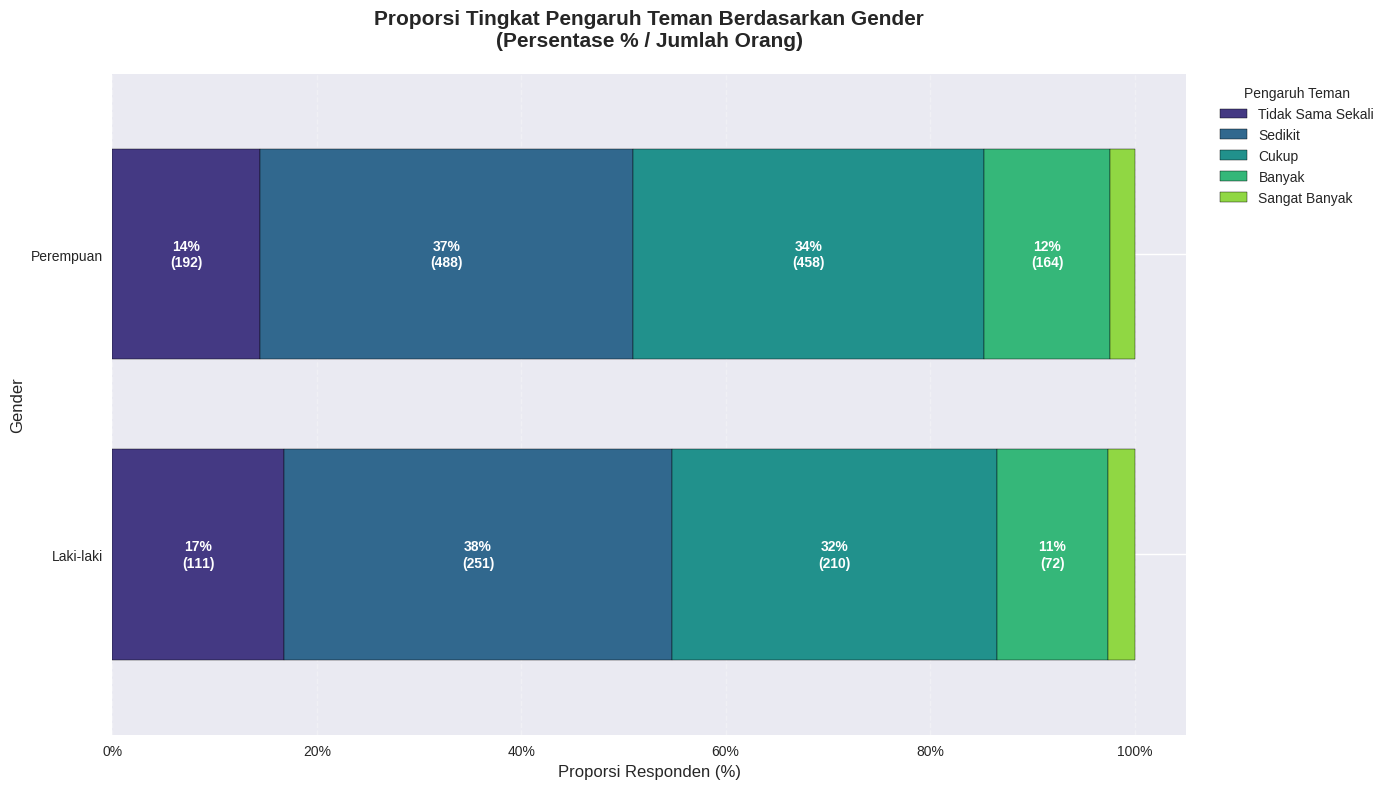

In [37]:
col_gender = 'gender'
col_peer = 'Peer_influance_decision'

# Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
order_peer = ['Tidak Sama Sekali', 'Sedikit', 'Cukup', 'Banyak', 'Sangat Banyak']

# Filter kategori
valid_peer = [x for x in order_peer if x in df[col_peer].unique()]

df_plot = df.copy()
df_plot[col_peer] = pd.Categorical(df_plot[col_peer], categories=valid_peer, ordered=True)

# Buat Tabel Kontingensi (Crosstab)
# Gender di baris (Sumbu Y), Peer Influence di kolom (Hue)
ct_counts = pd.crosstab(df_plot[col_gender], df_plot[col_peer])

# Tabel untuk persentase (untuk visualisasi bar 100%)
ct_pct = pd.crosstab(df_plot[col_gender], df_plot[col_peer], normalize='index') * 100

# Plotting
colors = sns.color_palette("viridis", n_colors=len(ct_pct.columns))
ax = ct_pct.plot( kind='barh', stacked=True,color=colors,figsize=(14, 8), width=0.7, edgecolor='black')

# Menambahkan Label Gabungan (Persen % / Jumlah)
for i, c in enumerate(ax.containers):
    # Ambil jumlah orang untuk kategori Peer Influence ke-i
    counts = ct_counts.iloc[:, i]

    labels = []
    for pct, count in zip(c.datavalues, counts):
        # Label hanya muncul jika proporsi > 3% agar tidak tumpang tindih
        if pct > 3:
            labels.append(f"{pct:.0f}%\n({count})")
        else:
            labels.append("")

    ax.bar_label(
        c,
        labels=labels,
        label_type='center',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

# Judul & Label
plt.title('Proporsi Tingkat Pengaruh Teman Berdasarkan Gender\n(Persentase % / Jumlah Orang)',
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Proporsi Responden (%)', fontsize=12)
plt.ylabel('Gender', fontsize=12)

# Mengatur Sumbu X menjadi Persen
plt.gca().xaxis.set_major_formatter(PercentFormatter())

plt.legend(title='Pengaruh Teman', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Simpan dan Tampilkan
plt.savefig('gender_vs_peer_hue.png', dpi=300)

plt.show()

Hubungan antara usia dan rasa takut ditolak

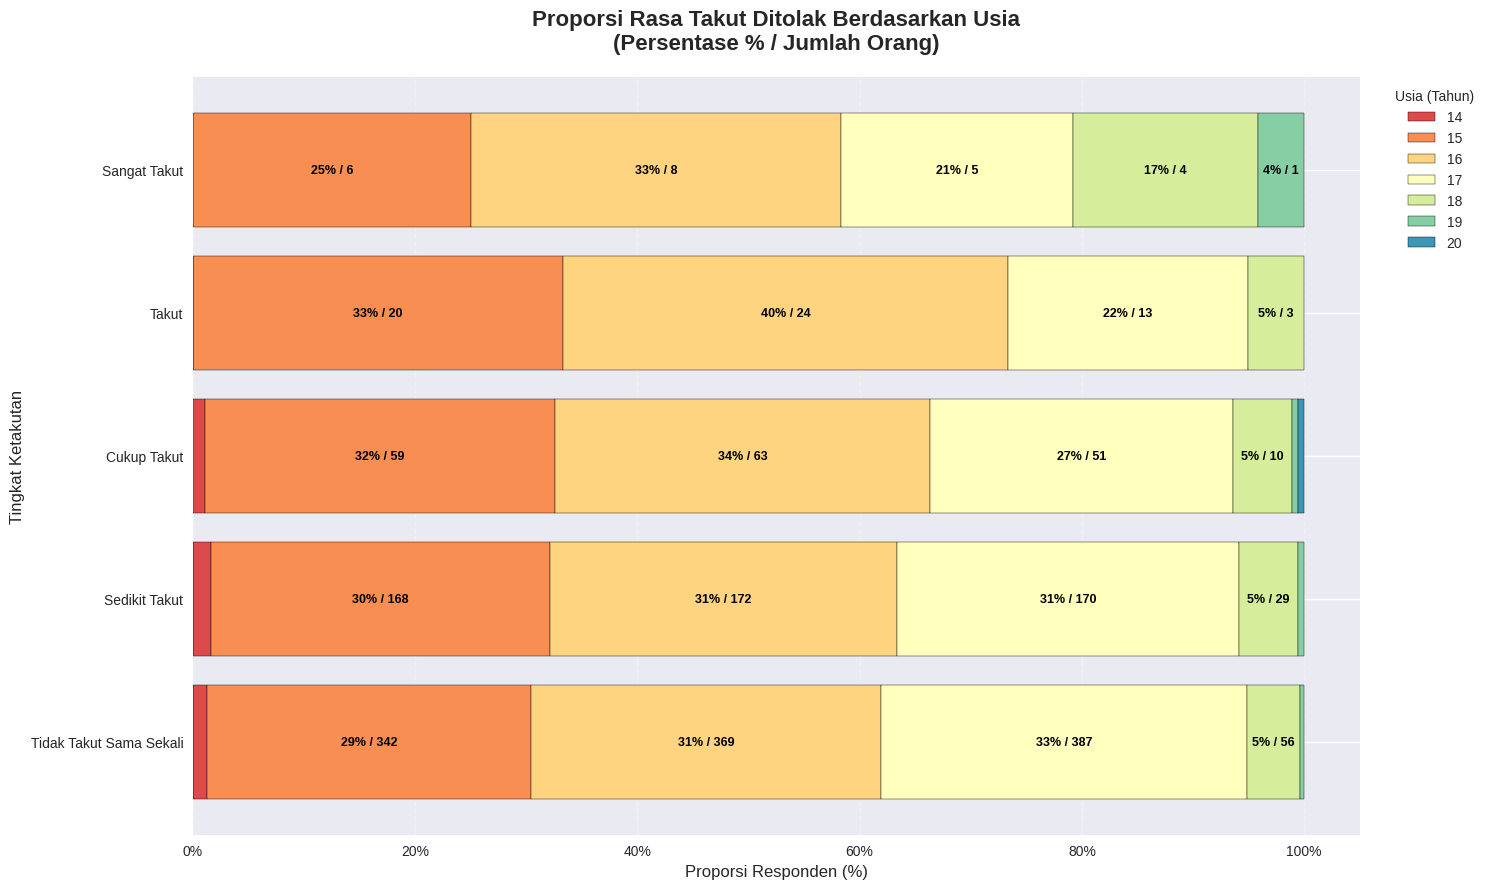

In [38]:
col_fear = 'fear_of_rejection'
col_usia = 'age'

if col_fear in df.columns and col_usia in df.columns:
    # Pembersihan & Filter Data Usia (SMA: 14-20)
    df[col_usia] = pd.to_numeric(df[col_usia], errors='coerce')
    df_clean = df[(df[col_usia] >= 14) & (df[col_usia] <= 20)].copy()
    df_clean[col_usia] = df_clean[col_usia].astype(int)

    # Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
    order_fear = ['Tidak Takut Sama Sekali','Sedikit Takut', 'Netral', 'Cukup Takut', 'Takut', 'Sangat Takut']

    # Filter kategori
    valid_fear = [x for x in order_fear if x in df_clean[col_fear].unique()]
    df_clean[col_fear] = pd.Categorical(df_clean[col_fear], categories=valid_fear, ordered=True)

    # Buat Tabel Kontingensi (Crosstab)
    ct_counts = pd.crosstab(df_clean[col_fear], df_clean[col_usia])

    # Tabel untuk persentase (untuk visualisasi bar 100%)
    ct_pct = pd.crosstab(df_clean[col_fear], df_clean[col_usia], normalize='index') * 100

    # Plotting
    colors = sns.color_palette("Spectral", n_colors=len(ct_pct.columns))
    ax = ct_pct.plot(kind='barh', stacked=True, color=colors, figsize=(15, 9), width=0.8, edgecolor='black')

    # Menambahkan Label Gabungan (Persen % / Jumlah)
    for i, c in enumerate(ax.containers):
        # Ambil kolom jumlah yang sesuai dengan kelompok usia saat ini
        counts = ct_counts.iloc[:, i]

        labels = []
        for pct, count in zip(c.datavalues, counts):
            # Label hanya muncul jika proporsi > 3% agar tidak tumpang tindih
            if pct > 3:
                labels.append(f"{pct:.0f}% / {count}")
            else:
                labels.append("")

        ax.bar_label(
            c,
            labels=labels,
            label_type='center',
            color='black', # Hitam lebih kontras dengan palet Spectral yang terang
            fontsize=9,
            fontweight='bold'
        )

    # Judul & Label
    plt.title('Proporsi Rasa Takut Ditolak Berdasarkan Usia\n(Persentase % / Jumlah Orang)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Proporsi Responden (%)', fontsize=12)
    plt.ylabel('Tingkat Ketakutan', fontsize=12)

    # Mengatur Sumbu X menjadi Persen
    plt.gca().xaxis.set_major_formatter(PercentFormatter())

    plt.legend(title='Usia (Tahun)', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Simpan dan Tampilkan
    plt.show()

else:
    print(f"Kolom '{col_fear}' atau '{col_usia}' tidak ditemukan dalam DataFrame.")

Hubungan antara penggunaan media sosial dan pengaruh influencer

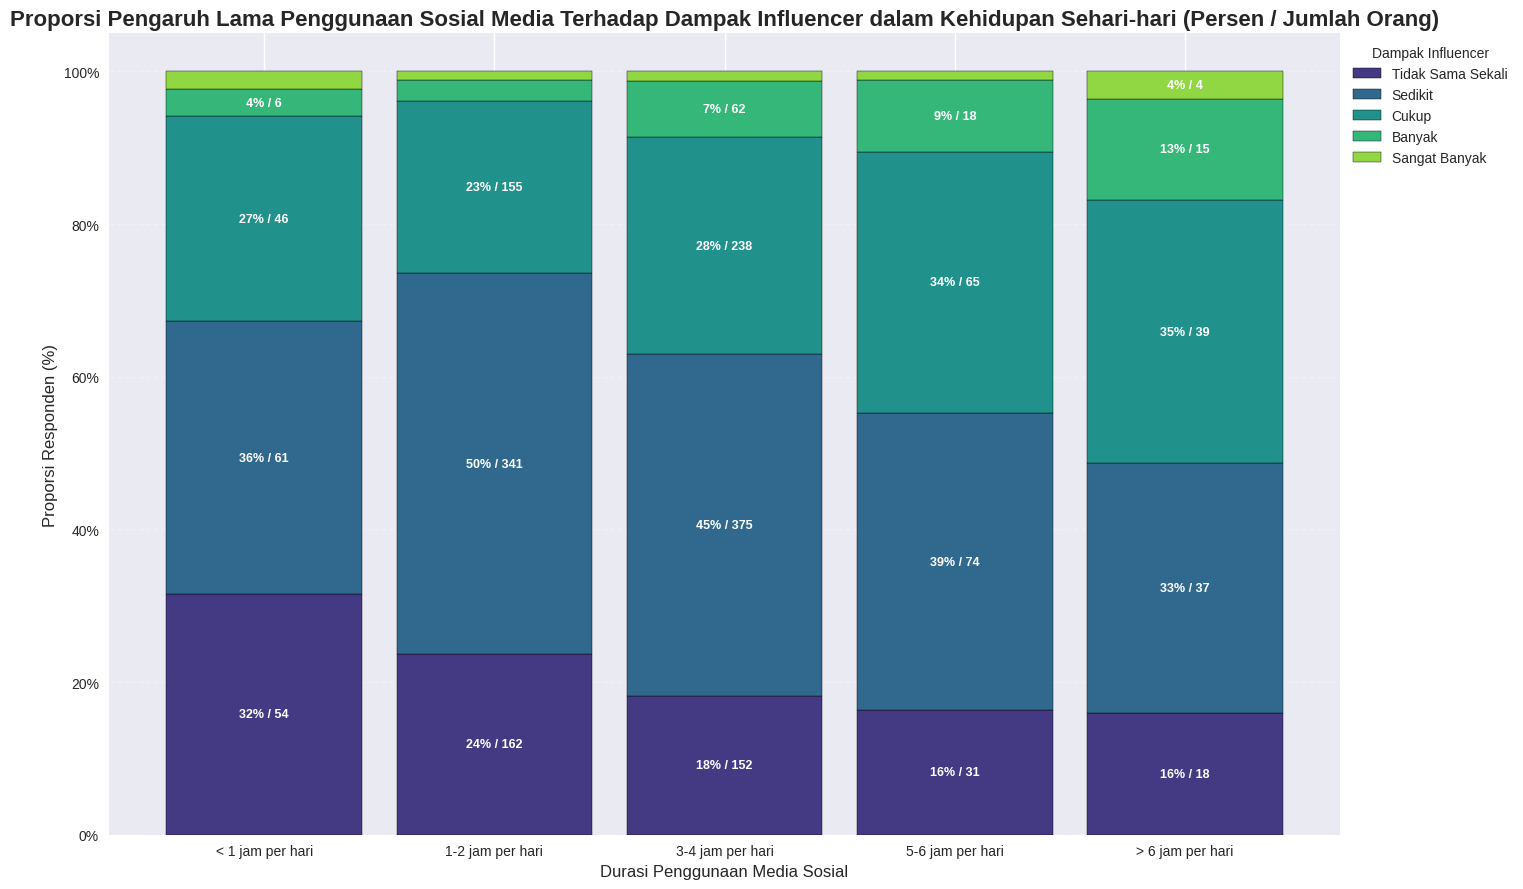

In [39]:
col_durasi = 'daily_social_media_hours'
col_influencer = 'influencer_impact'

if col_durasi in df.columns and col_influencer in df.columns:
    df[col_durasi] = df[col_durasi].astype(str).str.replace('–', '-', regex=False)

# Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
    order_durasi = ['< 1 jam per hari', '1-2 jam per hari', '3-4 jam per hari', '5-6 jam per hari', '> 6 jam per hari']
    order_influencer = ['Tidak Sama Sekali', 'Sedikit', 'Cukup', 'Banyak', 'Sangat Banyak']

# Filter kategori
    valid_durasi = [x for x in order_durasi if x in df[col_durasi].unique()]
    valid_inf = [x for x in order_influencer if x in df[col_influencer].unique()]

    df_plot = df.copy()
    df_plot[col_durasi] = pd.Categorical(df_plot[col_durasi], categories=valid_durasi, ordered=True)
    df_plot[col_influencer] = pd.Categorical(df_plot[col_influencer], categories=valid_inf, ordered=True)

# Buat Tabel Kontingensi (Crosstab)
# Tabel untuk jumlah riil (untuk label)
    ct_counts = pd.crosstab(df_plot[col_durasi], df_plot[col_influencer])

# Tabel untuk persentase (untuk visualisasi bar 100%)
    ct_pct = pd.crosstab(df_plot[col_durasi], df_plot[col_influencer], normalize='index') * 100

# Plotting
    colors = sns.color_palette("viridis", n_colors=len(ct_pct.columns))

    ax = ct_pct.plot(kind='bar', stacked=True, color=colors, figsize=(15, 9), width=0.85, edgecolor='black')

# Menambahkan Label Gabungan (Persen % / Jumlah)
    for i, c in enumerate(ax.containers):
        # Ambil kolom jumlah yang sesuai dengan warna saat ini
        counts = ct_counts.iloc[:, i]

        labels = []
        for pct, count in zip(c.datavalues, counts):
            # Label hanya muncul jika proporsi > 3% agar tidak tumpang tindih
            if pct > 3:
                label_text = f"{pct:.0f}% / {count}"
            else:
                label_text = ""
            labels.append(label_text)

        ax.bar_label(
            c,
            labels=labels,
            label_type='center',
            color='white',
            fontsize=9,
            fontweight='bold'
        )

# Judul & Label
    plt.title('Proporsi Pengaruh Lama Penggunaan Sosial Media Terhadap Dampak Influencer dalam Kehidupan Sehari-hari (Persen / Jumlah Orang)', fontsize=16, fontweight='bold')
    plt.xlabel('Durasi Penggunaan Media Sosial', fontsize=12)
    plt.ylabel('Proporsi Responden (%)', fontsize=12)
    plt.xticks(rotation=0)

    # Mengatur Sumbu X menjadi Persen
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.legend(title='Dampak Influencer', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()

# Simpan dan Tampilkan
    plt.savefig('medsos_influencer_combined_label.png')
    plt.show()

else:
    print("Kolom tidak ditemukan.")

analisis korelasi antar variabel numerik

In [40]:
numeric_cols = ['age', 'monthly_allowance', 'monthly_total_spending', 'spending_ratio']

In [41]:
df = df.rename(columns=rename_mapping)
corr_matrix = df[numeric_cols].corr()

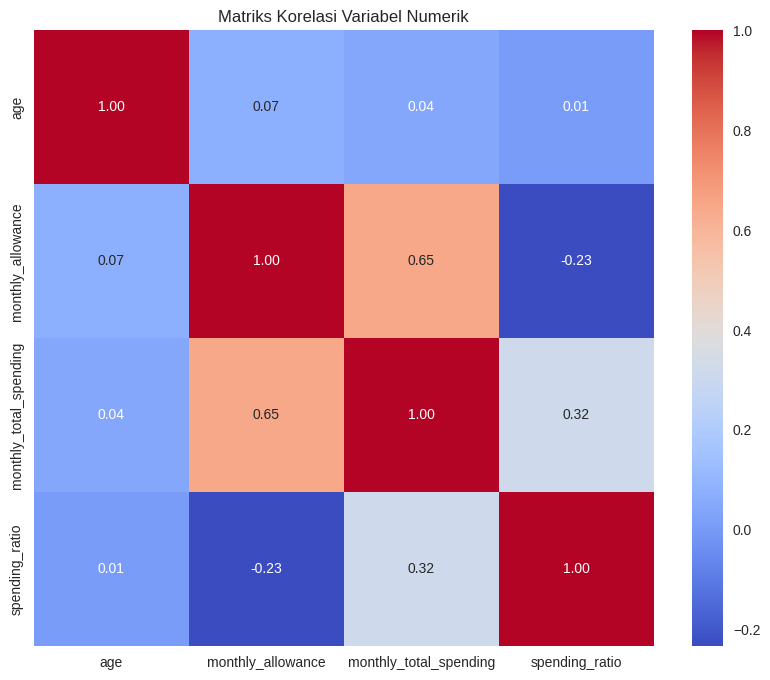

In [42]:
df = df.rename(columns=rename_mapping)
numeric_cols = ['age', 'monthly_allowance', 'monthly_total_spending', 'spending_ratio']
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi Variabel Numerik')
plt.savefig('correlation_matrix.png')
plt.show()

In [43]:
from scipy.stats import chi2_contingency

In [44]:
categorical_cols = [
    'gender', 'grade_level',
    'Peer_influance_decision',
    'fear_of_rejection',
    'peer_influenced_buying',
    'financial_status'
]

In [45]:
chi2_results = []
for i, col1 in enumerate(categorical_cols):
    for j, col2 in enumerate(categorical_cols):
        if i < j:  # Menghindari duplikasi
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            chi2_results.append({
                'Variable 1': col1,
                'Variable 2': col2,
                'Chi2': chi2,
                'P-value': p,
                'Significant': p < 0.05
            })

In [46]:
chi2_df = pd.DataFrame(chi2_results)
print("\nHasil Uji Chi-Square Antara Variabel Kategorikal:")
print(chi2_df.sort_values('P-value'))


Hasil Uji Chi-Square Antara Variabel Kategorikal:
                 Variable 1               Variable 2        Chi2  \
10  Peer_influance_decision   peer_influenced_buying  432.371165   
9   Peer_influance_decision        fear_of_rejection  197.008510   
12        fear_of_rejection   peer_influenced_buying  106.810907   
3                    gender   peer_influenced_buying   18.108325   
14   peer_influenced_buying         financial_status   18.091003   
0                    gender              grade_level    4.347191   
5               grade_level  Peer_influance_decision   12.420362   
4                    gender         financial_status    5.039654   
7               grade_level   peer_influenced_buying   11.452695   
2                    gender        fear_of_rejection    5.310160   
6               grade_level        fear_of_rejection    9.965298   
13        fear_of_rejection         financial_status   12.498451   
1                    gender  Peer_influance_decision    3.561558 

**Analisis hubungan antara tekanan sosial dan perilaku konsumtif**

> Hubungan antara tekanan teman dan pembelian impulsif



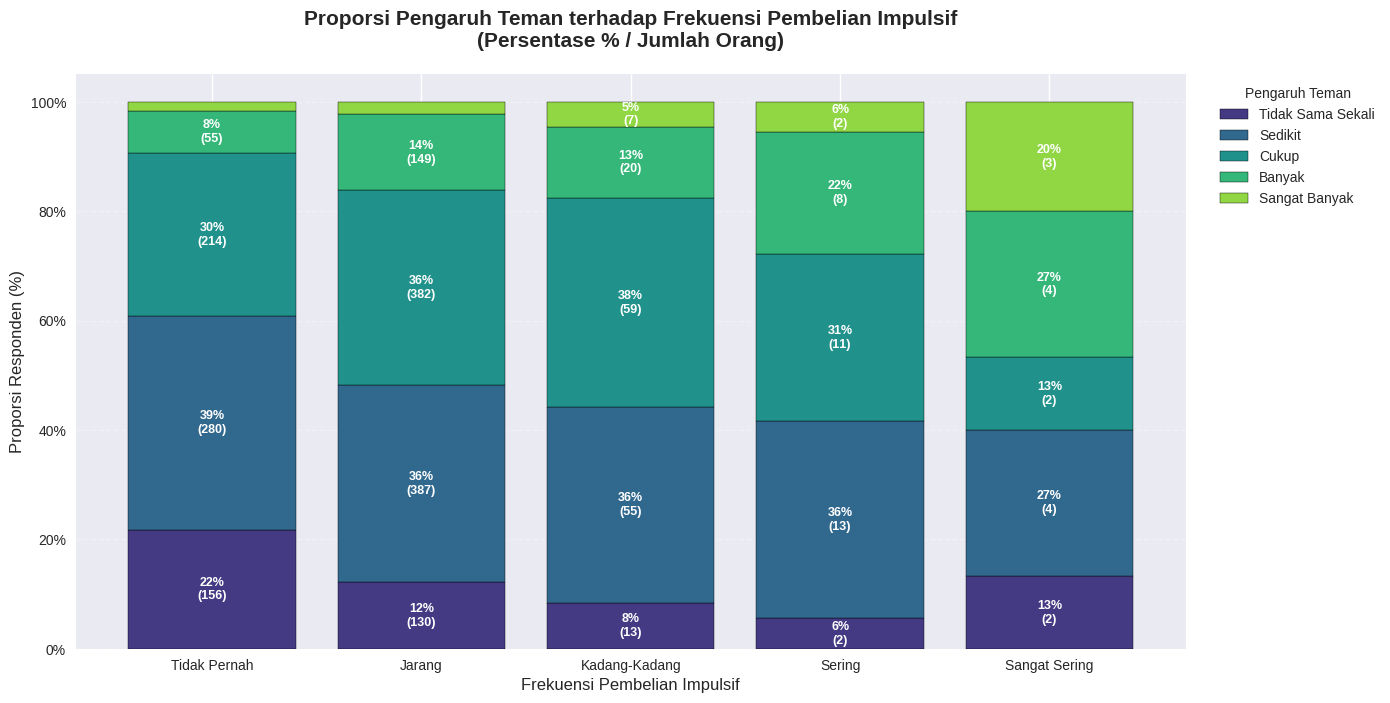

In [47]:
col_impulsive = 'freq_impulsive_buying'
col_peer = 'Peer_influance_decision'

# Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
order_impulsive = ['Tidak Pernah', 'Jarang', 'Kadang-Kadang', 'Sering', 'Sangat Sering']
order_peer = ['Tidak Sama Sekali', 'Sedikit', 'Cukup', 'Banyak', 'Sangat Banyak']

# Filter kategori
valid_imp = [x for x in order_impulsive if x in df[col_impulsive].unique()]
valid_peer = [x for x in order_peer if x in df[col_peer].unique()]

df_plot = df.copy()
df_plot[col_impulsive] = pd.Categorical(df_plot[col_impulsive], categories=valid_imp, ordered=True)
df_plot[col_peer] = pd.Categorical(df_plot[col_peer], categories=valid_peer, ordered=True)

# Buat Tabel Kontingensi (Crosstab)
ct_counts = pd.crosstab(df_plot[col_impulsive], df_plot[col_peer])

# Tabel untuk persentase (untuk visualisasi bar 100%)
ct_pct = pd.crosstab(df_plot[col_impulsive], df_plot[col_peer], normalize='index') * 100

# Plotting
colors = sns.color_palette("viridis", n_colors=len(ct_pct.columns))
ax = ct_pct.plot(kind='bar', stacked=True, color=colors, figsize=(14, 8), width=0.8, edgecolor='black')

# Menambahkan Label Gabungan (Persen % / Jumlah)
for i, c in enumerate(ax.containers):
    # Ambil kolom jumlah yang sesuai dengan kategori 'Peer Influence' saat ini
    counts = ct_counts.iloc[:, i]

    labels = []
    for pct, count in zip(c.datavalues, counts):
        # Hanya tampilkan label jika persentase > 3% agar tidak tumpang tindih
        if pct > 3:
            labels.append(f"{pct:.0f}%\n({count})")
        else:
            labels.append("")

    # Tempel label di tengah setiap segmen bar
    ax.bar_label(
        c,
        labels=labels,
        label_type='center',
        color='white',
        fontsize=9,
        fontweight='bold'
    )

# Judul & Label
plt.title('Proporsi Pengaruh Teman terhadap Frekuensi Pembelian Impulsif\n(Persentase % / Jumlah Orang)',
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Frekuensi Pembelian Impulsif', fontsize=12)
plt.ylabel('Proporsi Responden (%)', fontsize=12)

# Mengatur Sumbu Y menjadi Persen
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.legend(title='Pengaruh Teman', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=0)

# Simpan dan Tampilkan
plt.savefig('impulsive_vs_peer_combined.png', dpi=300)
plt.show()

Hubungan antara rasa takut ditolak dan pembelian untuk diterima

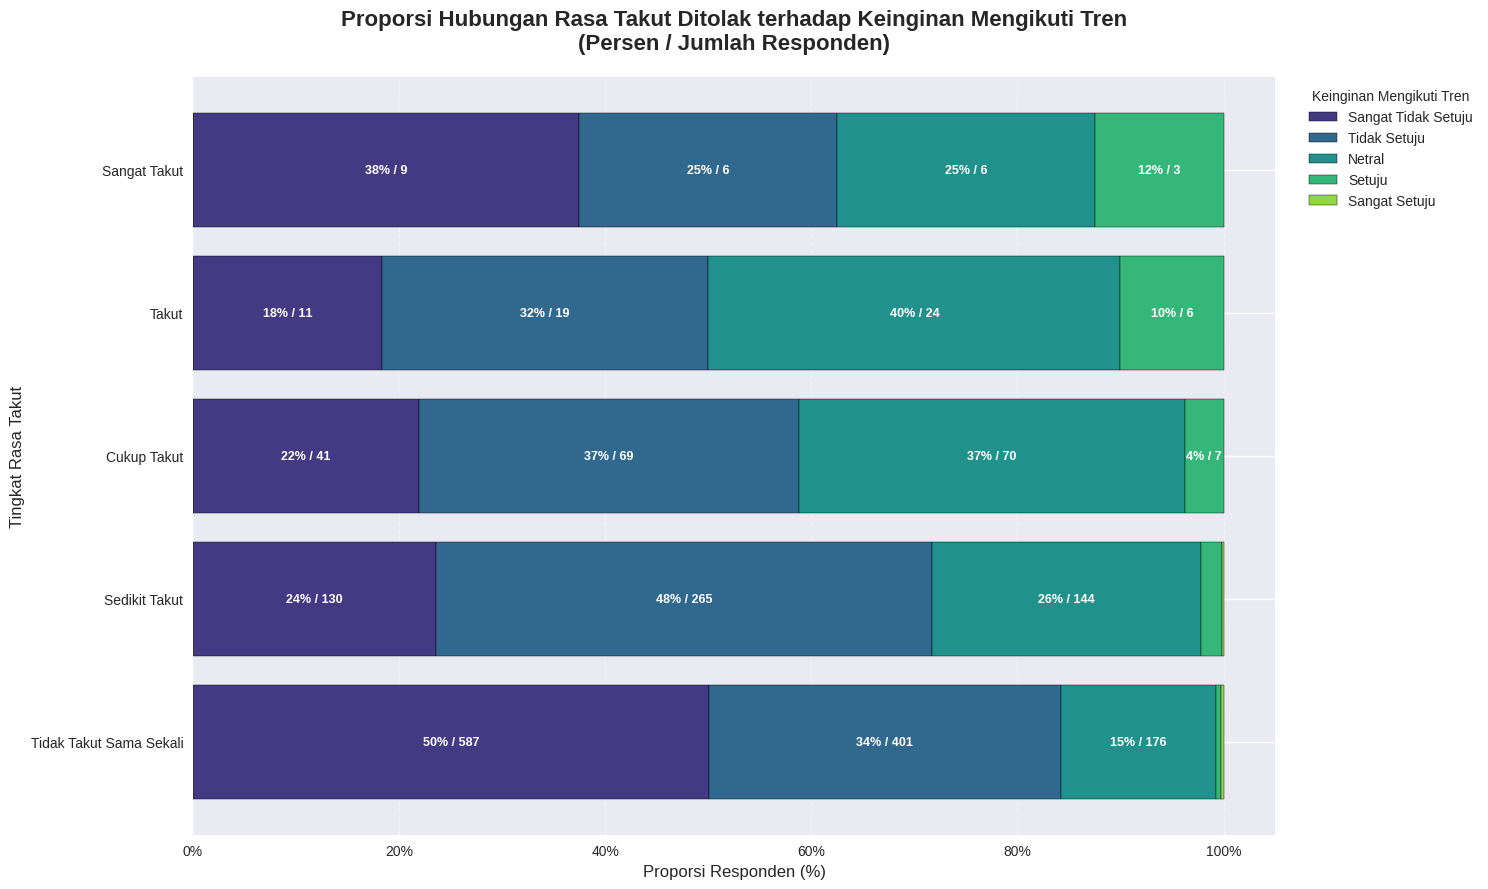

In [48]:
col_y = 'fear_of_rejection'
col_hue = 'attitude_need_trend_acceptance'

# Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
order_hue = ['Sangat Tidak Setuju', 'Tidak Setuju', 'Netral', 'Setuju', 'Sangat Setuju']
order_y = ['Tidak Takut Sama Sekali', 'Sedikit Takut', 'Cukup Takut', 'Takut', 'Sangat Takut']

# Filter kategori
valid_y = [x for x in order_y if x in df[col_y].unique()]
valid_hue = [x for x in order_hue if x in df[col_hue].unique()]

df_plot = df.copy()
df_plot[col_y] = pd.Categorical(df_plot[col_y], categories=valid_y, ordered=True)
df_plot[col_hue] = pd.Categorical(df_plot[col_hue], categories=valid_hue, ordered=True)

# Buat Tabel Kontingensi (Crosstab)
# Tabel untuk jumlah riil (untuk label)
ct_counts = pd.crosstab(df_plot[col_y], df_plot[col_hue])

# Tabel untuk persentase (untuk visualisasi bar 100%)
ct_pct = pd.crosstab(df_plot[col_y], df_plot[col_hue], normalize='index') * 100

# Plotting
colors = sns.color_palette("viridis", n_colors=len(ct_pct.columns))
ax = ct_pct.plot(kind='barh', stacked=True, color=colors, figsize=(15, 9), width=0.8, edgecolor='black')

# Menambahkan Label Gabungan (Persen % / Jumlah)
for i, c in enumerate(ax.containers):
    # Ambil kolom jumlah yang sesuai dengan kelompok (hue) saat ini
    counts = ct_counts.iloc[:, i]

    labels = []
    for pct, count in zip(c.datavalues, counts):
        # Label hanya muncul jika proporsi > 3% agar tidak tumpang tindih
        if pct > 3:
            labels.append(f"{pct:.0f}% / {count}")
        else:
            labels.append("")

    ax.bar_label(
        c,
        labels=labels,
        label_type='center',
        color='white',
        fontsize=9,
        fontweight='bold'
    )

# Judul & Label
plt.title('Proporsi Hubungan Rasa Takut Ditolak terhadap Keinginan Mengikuti Tren\n(Persen / Jumlah Responden)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Proporsi Responden (%)', fontsize=12)
plt.ylabel('Tingkat Rasa Takut', fontsize=12)

# Mengatur Sumbu X menjadi Persen
plt.gca().xaxis.set_major_formatter(PercentFormatter())

plt.legend(title='Keinginan Mengikuti Tren', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Simpan dan Tampilkan
plt.savefig('fear_vs_trend_stacked_100.png')
plt.show()

Hubungan antara pengaruh influencer dan pembelian online

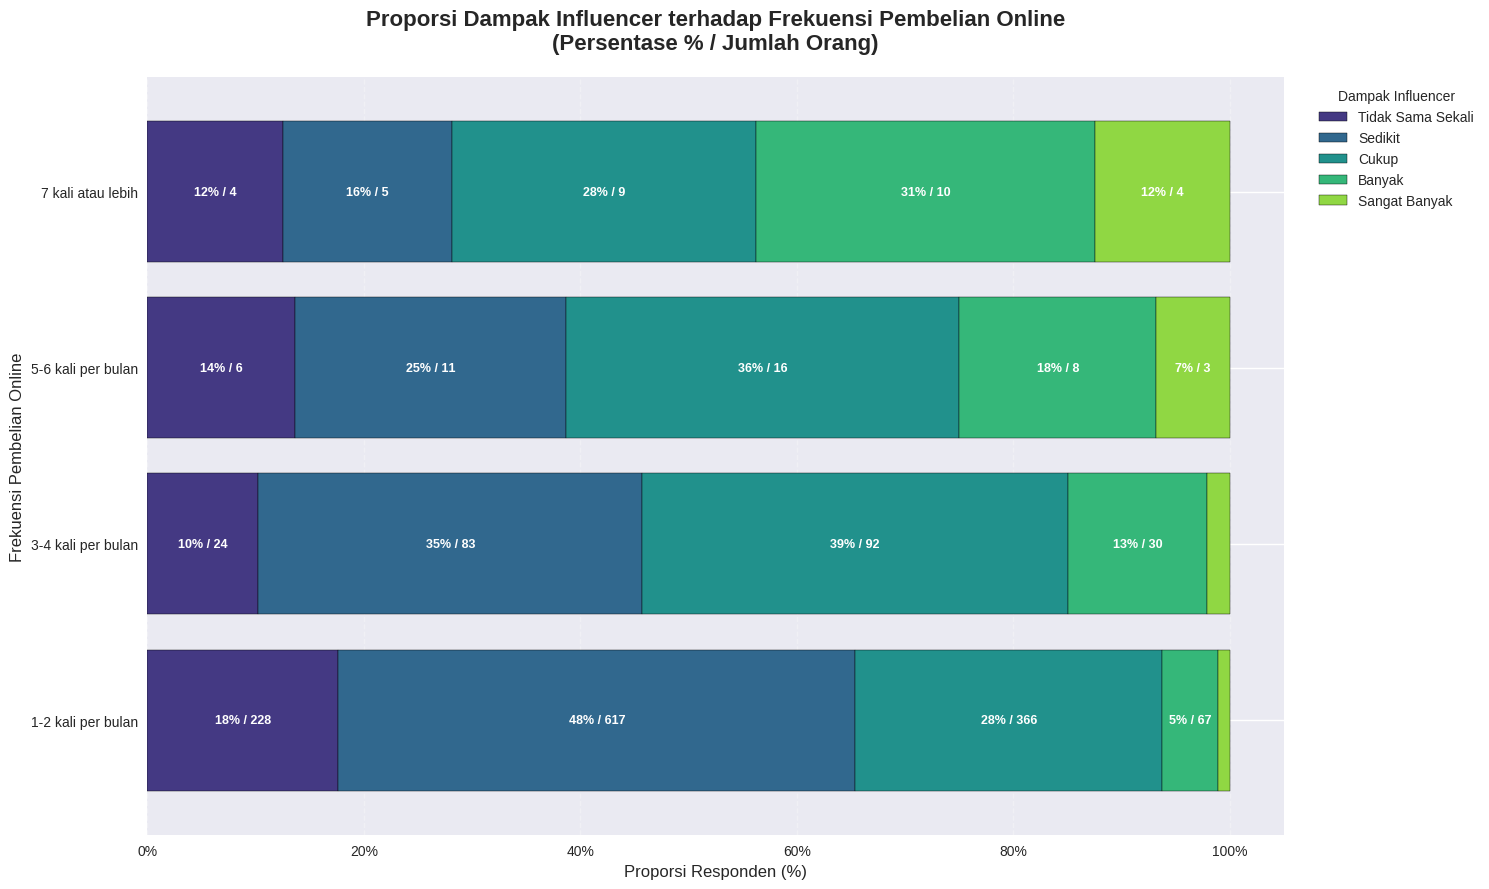

In [49]:
col_y = 'online_shopping_frequency'
col_hue = 'influencer_impact'

# Atur Urutan Kategori (Ordinal) agar grafik bercerita dengan logis
order_y = ['0 kali / Tidak pernah', '1-2 kali per bulan', '3-4 kali per bulan', '5-6 kali per bulan', '7 kali atau lebih']
order_hue = ['Tidak Sama Sekali', 'Sedikit', 'Cukup', 'Banyak', 'Sangat Banyak']

# Filter kategori
valid_y = [x for x in order_y if x in df[col_y].unique()]
valid_hue = [x for x in order_hue if x in df[col_hue].unique()]

df_plot = df.copy()
df_plot[col_y] = pd.Categorical(df_plot[col_y], categories=valid_y, ordered=True)
df_plot[col_hue] = pd.Categorical(df_plot[col_hue], categories=valid_hue, ordered=True)

# Buat Tabel Kontingensi (Crosstab)
# Tabel untuk jumlah riil (untuk label)
ct_counts = pd.crosstab(df_plot[col_y], df_plot[col_hue])

# Tabel untuk persentase (untuk visualisasi bar 100%)
ct_pct = pd.crosstab(df_plot[col_y], df_plot[col_hue], normalize='index') * 100

# Plotting
colors = sns.color_palette("viridis", n_colors=len(ct_pct.columns))
ax = ct_pct.plot(kind='barh', stacked=True, color=colors, figsize=(15, 9), width=0.8, edgecolor='black')

# Menambahkan Label Gabungan (Persen % / Jumlah)
for i, c in enumerate(ax.containers):
    # Ambil nilai count yang sesuai untuk kolom hue ke-i
    counts = ct_counts.iloc[:, i]

    labels = []
    for pct, count in zip(c.datavalues, counts):
        # Label hanya muncul jika proporsi > 3% agar tidak tumpang tindih
        if pct > 3:
            labels.append(f"{pct:.0f}% / {count}")
        else:
            labels.append("")

    ax.bar_label(
        c,
        labels=labels,
        label_type='center',
        color='white',
        fontsize=9,
        fontweight='bold'
    )

# Judul & Label
plt.title('Proporsi Dampak Influencer terhadap Frekuensi Pembelian Online\n(Persentase % / Jumlah Orang)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Proporsi Responden (%)', fontsize=12)
plt.ylabel('Frekuensi Pembelian Online', fontsize=12)

# Mengubah sumbu X menjadi format persen
plt.gca().xaxis.set_major_formatter(PercentFormatter())

plt.legend(title='Dampak Influencer', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Simpan dan Tampilkan
plt.savefig('influencer_vs_shopping_final.png')
plt.show()

In [50]:
import pandas as pd

# Load the dataset (assuming it's in the current directory)
df = pd.read_csv('cleaned_processed_final.csv')

# Get and print all column names
print(df.columns.tolist())

['Timestamp', 'Usia', 'JK', 'Sekolah', 'Kelas', 'Jumlah uang bulanan', 'Seberapa besar pengaruh teman-teman Anda dalam pengambilan keputusan sehari-hari (contohnya dalam memilih pakaian, tempat nongkrong dan barang yang ingin dibeli)?', 'Seberapa besar rasa takut Anda merasa ditolak dalam pertemanan jika dianggap ketinggalan tren atau tidak mengikuti gaya teman-teman Anda?', 'Seberapa sering Anda membeli suatu barang karena diajak atau dipengaruhi oleh teman Anda, bukan karena kebutuhan pribadi?', 'Dalam seminggu berapa kali Anda biasanya keluar untuk nongkrong  bersama teman?', 'Media sosial yang sering digunakan', 'Lama rata-rata Anda menggunakan media sosial', 'Seberapa besar pengaruh rekomendasi influencer terhadap pilihan belanja atau gaya hidup Anda?', 'Dalam satu bulan, berapa kali Anda melakukan pembelian melalui platform belanja online seperti Shopee, Tokopedia dan Tiktok Shop?', 'Seberapa sering Anda makan atau membeli jajanan diluar rumah dalam seminggu?', 'Total pengeluaran

**MODEL EVALUASI**

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('cleaned_processed_final.csv')

In [52]:
rename_mapping = {
    'Timestamp': 'Timestamp',
    'Usia': 'age',
    'JK': 'gender',
    'Sekolah': 'school',
    'Kelas': 'grade_level',
    'Jumlah uang bulanan': 'monthly_allowance',
    'Total pengeluaran dalam satu bulan': 'monthly_total_spending',
    'Seberapa besar pengaruh teman-teman Anda dalam pengambilan keputusan sehari-hari (contohnya dalam memilih pakaian, tempat nongkrong dan barang yang ingin dibeli)?': 'peer_influence_decision',
    'Seberapa besar rasa takut Anda merasa ditolak dalam pertemanan jika dianggap ketinggalan tren atau tidak mengikuti gaya teman-teman Anda?': 'fear_of_rejection',
    'Seberapa sering Anda membeli suatu barang karena diajak atau dipengaruhi oleh teman Anda, bukan karena kebutuhan pribadi?': 'peer_influenced_buying',
    'Dalam seminggu berapa kali Anda biasanya keluar untuk nongkrong  bersama teman?': 'hangout_freq',
    'Media sosial yang sering digunakan': 'social_media_used',
    'Lama rata-rata Anda menggunakan media sosial': 'social_media_duration',
    'Seberapa besar pengaruh rekomendasi influencer terhadap pilihan belanja atau gaya hidup Anda?': 'influencer_impact',
    'Dalam satu bulan, berapa kali Anda melakukan pembelian melalui platform belanja online seperti Shopee, Tokopedia dan Tiktok Shop?': 'online_shopping_freq',
    'Seberapa sering Anda makan atau membeli jajanan diluar rumah dalam seminggu?': 'eating_out_freq',
    'Seberapa sering Anda membeli barang dalam satu bulan (termasuk jajan, nongkrong, belanja dan kebutuhan lainnya)?': 'general_buying_freq',
    'Seberapa sering Anda membeli barang secara spontan tanpa perencanaan sebelumnya (impulsive buying)?': 'impulsive_buying_freq',
    'Saya merasa perlu membeli barang-barang yang sedang tren agar saya dapat diterima dalam kelompok pertemanan saya': 'need_trend_acceptance',
    'Sebagian besar uang saku saya habis karena kegiatan bersama teman, seperti nongkrong, makan diluar atau mengikuti tren lain?': 'money_spent_on_friends',
    'Saya sering merasa terdorong untuk mencoba tempat-tempat yang sedang tren di media sosial karena banyak teman saya yang melakukannya': 'driven_by_social_trends',
    'Saya rela mengurangi atau menghemat uang makan dan transportasi agar bisa membeli barang atau mengikuti tren yang sedang populer di sekolah': 'sacrifice_basic_needs_for_trends',
    'Frekuensi saya nongkrong di kafe atau tempat hangout tertentu meningkat karena sering diajak atau dipengaruhi oleh teman': 'hangout_increase_due_to_friends'
}
df = df.rename(columns=rename_mapping)

In [53]:
df['age'] = df['age'].fillna(df['age'].median())

In [54]:
map_freq = {
    'Tidak Pernah': 0, 'Tidak pernah': 0, '0 kali / Tidak pernah': 0, '0 kali /  Tidak pernah': 0,
    'Jarang': 1, 'Kadang-kadang': 2, 'Sering': 3, 'Sangat Sering': 4, 'Sangat sering': 4
}

map_agree = {
    'Sangat Tidak Setuju': 1, 'Tidak Setuju': 2, 'Netral': 3, 'Setuju': 4, 'Sangat Setuju': 5
}

map_influence = {
    'Tidak Sama Sekali': 0, 'Tidak sama sekali': 0,
    'Sedikit': 1, 'Cukup': 2, 'Banyak': 3, 'Sangat Banyak': 4, 'Sangat banyak': 4
}

map_fear = {
    'Tidak Takut Sama Sekali': 0, 'Tidak takut sama sekali': 0,
    'Sedikit takut': 1, 'Cukup takut': 2, 'Takut': 3, 'Sangat takut': 4
}

map_duration = {'< 1 jam per hari': 0, '1–2 jam per hari': 1, '3–4 jam per hari': 2, '5–6 jam per hari': 3, '> 6 jam per hari': 4}
map_hangout = {'0 kali / Tidak pernah': 0, '1-2 kali per minggu': 1, '3-4 kali per minggu': 2, '5-6 kali per minggu': 3, '7 kali atau lebih': 4}
map_online = {'0 kali /  Tidak pernah': 0, '1-2 kali per bulan': 1, '3-4 kali per bulan': 2, '5-6 kali per bulan': 3, '7 kali atau lebih': 4}

def clean_impulsive(val):
    if str(val) in ['0', 'Tidak Pernah']: return 0
    if str(val) == 'Jarang': return 1
    if str(val) in ['1-3', 'Kadang-kadang']: return 2
    if str(val) in ['4-6', 'Sering']: return 3
    if str(val) in ['7-9']: return 4
    if str(val) in ['>= 10', 'Sangat Sering']: return 5
    return 0

In [55]:
freq_cols = ['peer_influenced_buying', 'eating_out_freq', 'general_buying_freq']
for col in freq_cols:
    df[col + '_enc'] = df[col].map(map_freq)

agree_cols = ['need_trend_acceptance', 'money_spent_on_friends', 'driven_by_social_trends',
              'sacrifice_basic_needs_for_trends', 'hangout_increase_due_to_friends']
for col in agree_cols:
    df[col + '_enc'] = df[col].map(map_agree)

df['peer_influence_decision_enc'] = df['peer_influence_decision'].map(map_influence)
df['fear_of_rejection_enc'] = df['fear_of_rejection'].map(map_fear)
df['influencer_impact_enc'] = df['influencer_impact'].map(map_influence)
df['hangout_freq_enc'] = df['hangout_freq'].map(map_hangout)
df['social_media_duration_enc'] = df['social_media_duration'].map(map_duration)
df['online_shopping_freq_enc'] = df['online_shopping_freq'].map(map_online)
df['impulsive_buying_freq_enc'] = df['impulsive_buying_freq'].apply(clean_impulsive)

df['gender_enc'] = df['gender'].map({'Laki-laki': 0, 'Perempuan': 1})

status_map = {'Hemat': 0, 'Wajar': 1, 'Boros': 2, 'Defisit (Nombok)': 3}
df['Status_Keuangan_enc'] = df['Status_Keuangan'].map(status_map)

In [56]:
fomo_feature_cols = [
    'fear_of_rejection_enc',
    'need_trend_acceptance_enc',
    'driven_by_social_trends_enc',
    'peer_influence_decision_enc'
]

In [57]:
df['fomo_score'] = df[fomo_feature_cols].mean(axis=1)

In [58]:
feature_cols = [
    'age', 'gender_enc', 'monthly_allowance',
    'peer_influenced_buying_enc', 'eating_out_freq_enc', 'general_buying_freq_enc',
    'need_trend_acceptance_enc', 'money_spent_on_friends_enc', 'driven_by_social_trends_enc',
    'sacrifice_basic_needs_for_trends_enc', 'hangout_increase_due_to_friends_enc',
    'peer_influence_decision_enc', 'fear_of_rejection_enc', 'influencer_impact_enc',
    'hangout_freq_enc', 'social_media_duration_enc', 'online_shopping_freq_enc',
    'impulsive_buying_freq_enc',
    'fomo_score'
]
df_model = df.dropna(subset=feature_cols + ['Status_Keuangan_enc', 'monthly_total_spending'])

Membuat Model Klasifikasi ( Random Forest )

In [59]:
X = df_model[feature_cols]
y = df_model['Status_Keuangan_enc']

In [60]:
# Bagi Data menjadi Training (80%) dan Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan Latih Model Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
y_pred = rf_clf.predict(X_test)

Evaluasi Hasil

In [62]:
target_names = ['Hemat', 'Wajar', 'Boros', 'Defisit']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

       Hemat       0.67      0.11      0.19        18
       Wajar       0.33      0.25      0.29        48
       Boros       0.41      0.55      0.47        71
     Defisit       0.31      0.33      0.32        46

    accuracy                           0.37       183
   macro avg       0.43      0.31      0.32       183
weighted avg       0.39      0.37      0.36       183



In [63]:
importances = rf_clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

/tmp/ipython-input-1675533101.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


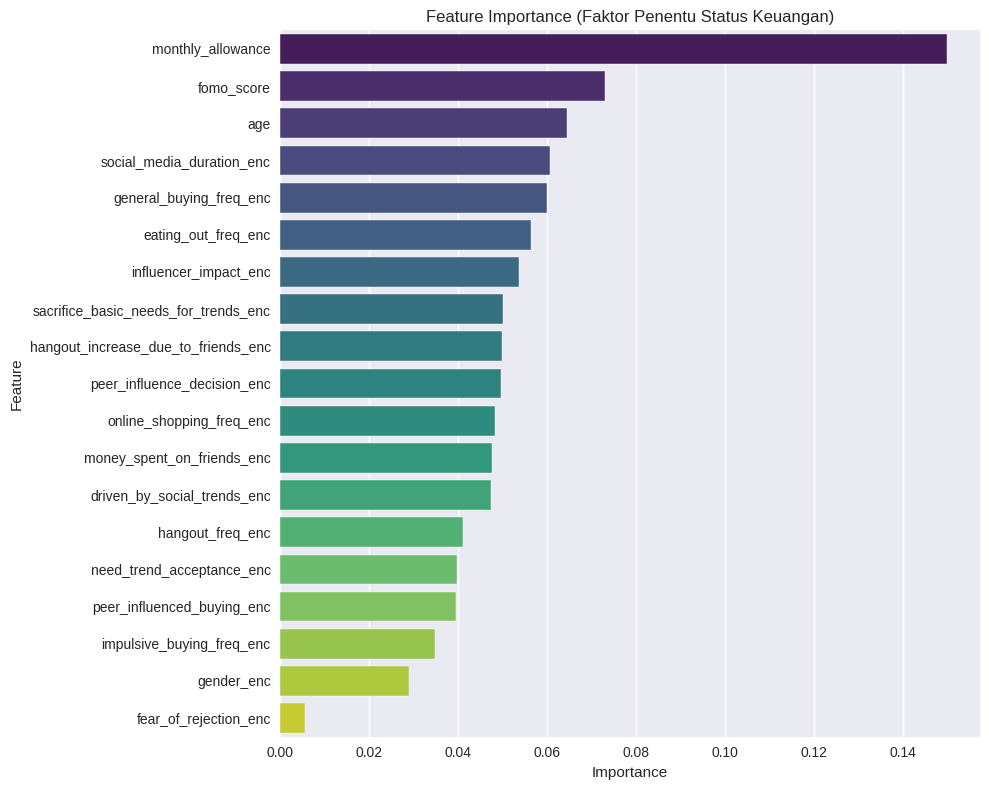

In [64]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance (Faktor Penentu Status Keuangan)')
plt.tight_layout()
plt.show()

In [65]:
print("Feature Importance (dengan FOMO Score):")
print(feature_imp_df)

Feature Importance (dengan FOMO Score):
                                 Feature  Importance
2                      monthly_allowance    0.149807
18                            fomo_score    0.073012
0                                    age    0.064407
15             social_media_duration_enc    0.060650
5                general_buying_freq_enc    0.060035
4                    eating_out_freq_enc    0.056345
13                 influencer_impact_enc    0.053653
9   sacrifice_basic_needs_for_trends_enc    0.050042
10   hangout_increase_due_to_friends_enc    0.049860
11           peer_influence_decision_enc    0.049627
16              online_shopping_freq_enc    0.048290
7             money_spent_on_friends_enc    0.047511
8            driven_by_social_trends_enc    0.047365
14                      hangout_freq_enc    0.041101
6              need_trend_acceptance_enc    0.039797
3             peer_influenced_buying_enc    0.039418
17             impulsive_buying_freq_enc    0.034664
1     

Model Linear Regression ( Prediksi )

In [66]:
target_reg = 'monthly_total_spending'

In [67]:
features_reg = feature_cols

In [68]:
df_reg = df.dropna(subset=features_reg + [target_reg])

X_reg = df_reg[features_reg]
y_reg = df_reg[target_reg]

In [69]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [70]:
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)

LinearRegression()

In [71]:
y_pred_reg = lr_model.predict(X_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print("=== HASIL EVALUASI LINEAR REGRESSION ===")
print(f"R-Squared (Seberapa baik model menjelaskan data): {r2:.4f}")
print(f"MAE (Rata-rata prediksi meleset sebesar): Rp {mae:,.0f}")
print(f"RMSE (Tingkat kesalahan kuadratik): Rp {rmse:,.0f}")

=== HASIL EVALUASI LINEAR REGRESSION ===
R-Squared (Seberapa baik model menjelaskan data): 0.2864
MAE (Rata-rata prediksi meleset sebesar): Rp 126,513
RMSE (Tingkat kesalahan kuadratik): Rp 309,856


/tmp/ipython-input-726834768.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


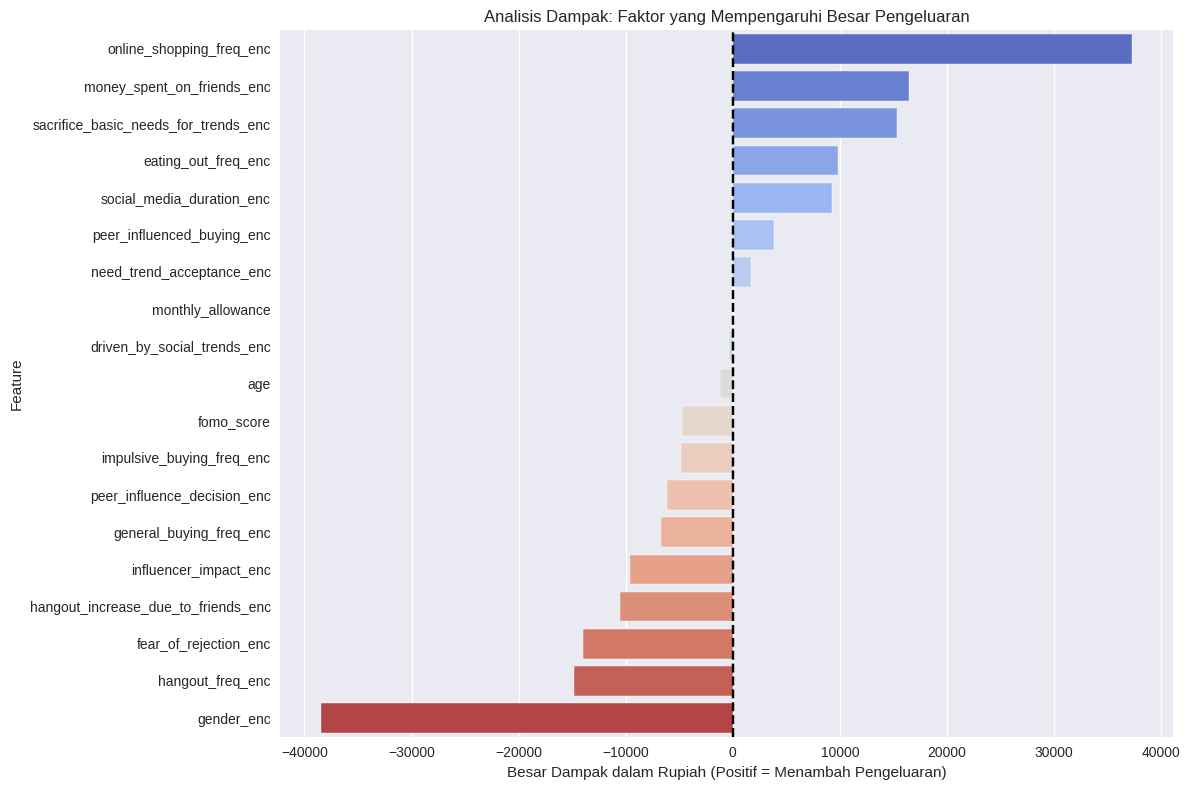

In [72]:
coef_df = pd.DataFrame({'Feature': features_reg, 'Coefficient': lr_model.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Analisis Dampak: Faktor yang Mempengaruhi Besar Pengeluaran')
plt.xlabel('Besar Dampak dalam Rupiah (Positif = Menambah Pengeluaran)')
plt.axvline(x=0, color='black', linestyle='--') # Garis tengah nol
plt.tight_layout()
plt.show()

In [73]:
print("\nTop 5 Faktor Pendorong Pengeluaran Tinggi:")
print(coef_df.head(5))


Top 5 Faktor Pendorong Pengeluaran Tinggi:
                                 Feature   Coefficient
16              online_shopping_freq_enc  37284.014221
7             money_spent_on_friends_enc  16418.095795
9   sacrifice_basic_needs_for_trends_enc  15292.902301
4                    eating_out_freq_enc   9785.900594
15             social_media_duration_enc   9246.890728


Prediksi menggunakan random forest regresor

In [74]:
target_impulsive = 'impulsive_buying_freq_enc'

In [75]:
features_imp = [col for col in feature_cols if col != 'impulsive_buying_freq_enc']

In [76]:
df_imp = df.dropna(subset=features_imp + [target_impulsive])
X_imp = df_imp[features_imp]
y_imp = df_imp[target_impulsive]

In [77]:
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=42)

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_imp_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_imp_model.fit(X_train_imp, y_train_imp)

RandomForestRegressor(random_state=42)

In [79]:
y_pred_imp = rf_imp_model.predict(X_test_imp)

mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)
r2_imp = r2_score(y_test_imp, y_pred_imp)

print(f"\n=== EVALUASI MODEL PREDIKSI IMPULSIVE BUYING ===")
print(f"R-Squared: {r2_imp:.4f}")
print(f"MAE (Rata-rata kesalahan prediksi skala 0-5): {mae_imp:.2f} poin")


=== EVALUASI MODEL PREDIKSI IMPULSIVE BUYING ===
R-Squared: -0.0489
MAE (Rata-rata kesalahan prediksi skala 0-5): 0.50 poin


/tmp/ipython-input-2134710069.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df2, palette='magma')


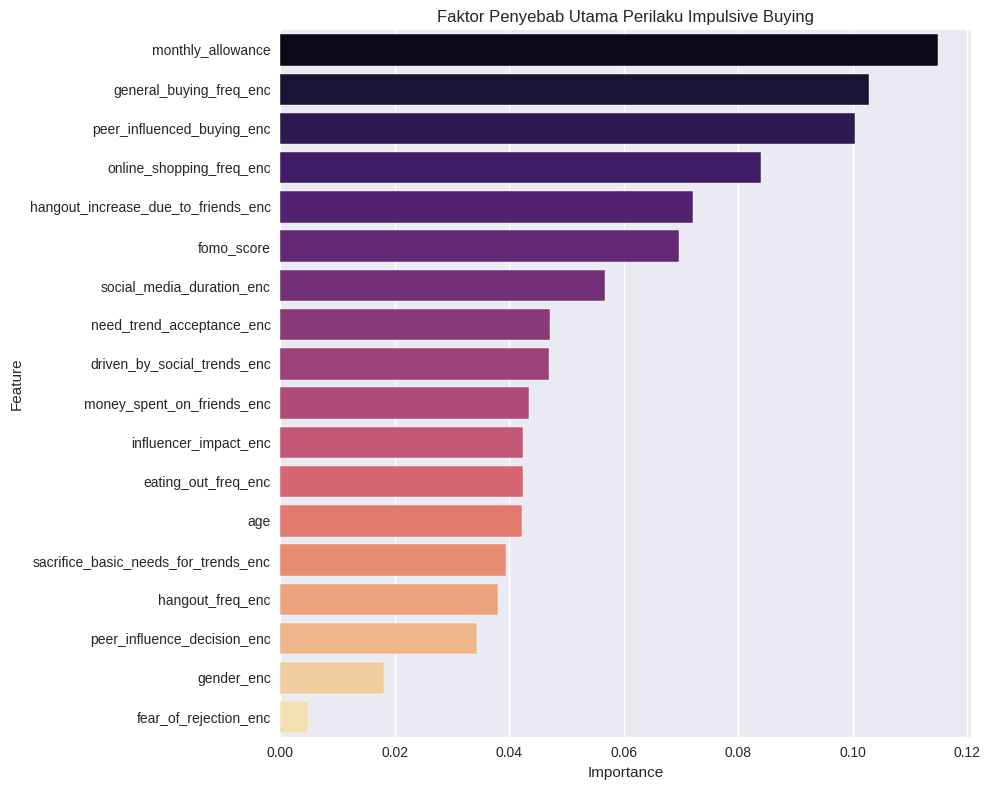

In [80]:
importances_imp = rf_imp_model.feature_importances_
feature_imp_df2 = pd.DataFrame({'Feature': features_imp, 'Importance': importances_imp})
feature_imp_df2 = feature_imp_df2.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df2, palette='magma')
plt.title('Faktor Penyebab Utama Perilaku Impulsive Buying')
plt.tight_layout()
plt.show()

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [82]:
cluster_features = [
    'monthly_allowance',          # Kemampuan finansial
    'monthly_total_spending',     # Realisasi pengeluaran
    'peer_influence_decision_enc',# Tingkat pengaruh teman
    'fear_of_rejection_enc',      # Faktor psikologis
    'peer_influenced_buying_enc', # Perilaku belanja sosial
    'hangout_freq_enc',           # Gaya hidup nongkrong
    'social_media_duration_enc',  # Gaya hidup digital
    'online_shopping_freq_enc',   # Kebiasaan belanja online
    'impulsive_buying_freq_enc',  # Kebiasaan impulsif
    'eating_out_freq_enc'         # Kebiasaan jajan
]

In [83]:
df_cluster = df.dropna(subset=cluster_features).copy()
X_cluster = df_cluster[cluster_features]

In [84]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [85]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

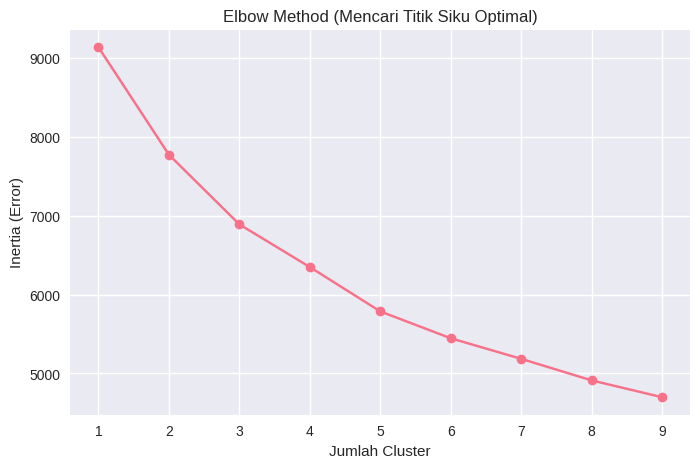

In [86]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Mencari Titik Siku Optimal)')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia (Error)')
plt.grid(True)
plt.show()

In [87]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cluster['Cluster_Label'] = kmeans.fit_predict(X_scaled)

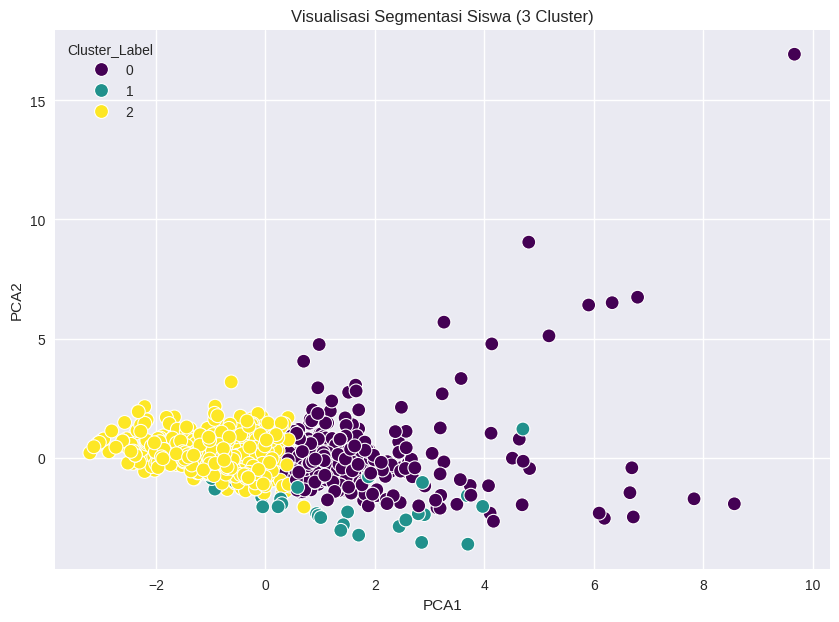

In [88]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Label', data=df_cluster, palette='viridis', s=100)
plt.title(f'Visualisasi Segmentasi Siswa (3 Cluster)')
plt.show()

In [89]:
cluster_summary = df_cluster.groupby('Cluster_Label')[cluster_features].mean()

# Format tampilan angka agar mudah dibaca
pd.options.display.float_format = '{:,.2f}'.format
print("Rata-rata Perilaku per Cluster:")
print(cluster_summary.T) # Transpose agar mudah dibaca vertikal

print("\nJumlah Siswa per Cluster:")
print(df_cluster['Cluster_Label'].value_counts())

Rata-rata Perilaku per Cluster:
Cluster_Label                        0          1          2
monthly_allowance           403,554.28 290,428.59 203,514.51
monthly_total_spending      405,130.83 244,914.30 190,484.32
peer_influence_decision_enc       1.76       2.06       0.98
fear_of_rejection_enc             0.00       3.00       0.00
peer_influenced_buying_enc        1.42       1.71       0.71
hangout_freq_enc                  1.00       0.66       0.54
social_media_duration_enc         2.19       1.91       1.37
online_shopping_freq_enc          1.50       0.86       0.75
impulsive_buying_freq_enc         0.99       0.71       0.39
eating_out_freq_enc               2.60       2.03       1.47

Jumlah Siswa per Cluster:
Cluster_Label
2    621
0    258
1     35
Name: count, dtype: int64


In [90]:
import joblib
import os
import json

folder_path = 'models'
os.makedirs(folder_path, exist_ok=True)

print(f"Folder '{folder_path}' siap digunakan.\n")


# 1. Simpan Random Forest Classifier (Klasifikasi Status Keuangan)
if 'rf_clf' in globals():
    path = os.path.join(folder_path, 'model_klasifikasi_status_keuangan.joblib')
    joblib.dump(rf_clf, path)
    print(f"✅ Tersimpan: {path}")
else:
    print("❌ Skip: rf_clf tidak ditemukan (pastikan code klasifikasi sudah dijalankan).")

# 2. Simpan Linear Regression (Prediksi Nominal Pengeluaran)
if 'lr_model' in globals():
    path = os.path.join(folder_path, 'model_regresi_pengeluaran.joblib')
    joblib.dump(lr_model, path)
    print(f"✅ Tersimpan: {path}")
else:
    print("❌ Skip: lr_model tidak ditemukan.")

# 3. Simpan Random Forest Regressor (Prediksi Impulsive Buying)
if 'rf_imp_model' in globals():
    path = os.path.join(folder_path, 'model_regresi_impulsive.joblib')
    joblib.dump(rf_imp_model, path)
    print(f"✅ Tersimpan: {path}")
else:
    print("❌ Skip: rf_imp_model tidak ditemukan.")

# 4. Simpan K-Means Clustering & Scaler
if 'kmeans' in globals():
    path_kmeans = os.path.join(folder_path, 'model_kmeans_clustering.joblib')
    joblib.dump(kmeans, path_kmeans)
    print(f"✅ Tersimpan: {path_kmeans}")

    # PENTING: Simpan Scaler juga! (K-Means butuh data yang discale sama persis)
    if 'scaler' in globals():
        path_scaler = os.path.join(folder_path, 'scaler_untuk_clustering.joblib')
        joblib.dump(scaler, path_scaler)
        print(f"✅ Tersimpan: {path_scaler}")
else:
    print("❌ Skip: Model K-Means tidak ditemukan.")


mapping_data = {
    'map_freq': map_freq,
    'map_agree': map_agree,
    'map_influence': map_influence,
    'map_fear': map_fear,
    'map_duration': map_duration,
    'map_hangout': map_hangout,
    'map_online': map_online,
    'status_map': status_map
}

json_path = os.path.join(folder_path, 'encoding_mappings.json')
with open(json_path, 'w') as f:
    json.dump(mapping_data, f)
print(f"✅ Tersimpan: {json_path} (Kamus Encoding)")

print("\n🎉 Selesai! Semua file model ada di dalam folder 'models'.")

Folder 'models' siap digunakan.

✅ Tersimpan: models/model_klasifikasi_status_keuangan.joblib
✅ Tersimpan: models/model_regresi_pengeluaran.joblib
✅ Tersimpan: models/model_regresi_impulsive.joblib
✅ Tersimpan: models/model_kmeans_clustering.joblib
✅ Tersimpan: models/scaler_untuk_clustering.joblib
✅ Tersimpan: models/encoding_mappings.json (Kamus Encoding)

🎉 Selesai! Semua file model ada di dalam folder 'models'.
